In [1]:
import colorlover as cl
import ast
import jenkspy
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import factory as importer
from matplotlib import collections as mc
from matplotlib import cm
import datetime
import pandas as pd
import numpy as np
import copy
%aimport BEP_PM
from sklearn import linear_model

In [8]:
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

In [7]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPI Challenge 2017.xes',[True])
bpi = BEP_PM.EventLog('BPI2017', 'concept:name', 'time:timestamp', log, resource_id='org:resource')

In [8]:
pf = pd.concat([pd.DataFrame(log[i]) for i in range(len(log))])
pf.loc[pf.index == 0, 'case_id'] = [i for i in range((pf.index == 0).sum())]
pf['case_id'] = pf['case_id'].fillna(method='ffill')
pf.sort_values(["case_id", "concept:name", "time:timestamp"], inplace=True)
df = pf[['case_id', "concept:name", "lifecycle:transition","org:resource","time:timestamp"]]

In [9]:
df = df[df['concept:name'].str.contains('W')]

In [10]:
df = df.sort_values(['case_id', 'time:timestamp', 'concept:name'])

In [11]:
t = pd.concat([df, df.shift(-1)], axis=1)
t.columns = [str(i)+str(k//5) for k,i in enumerate(t.columns)]

In [12]:
t = t[(t['concept:name0'] == t['concept:name1']) & (t['case_id0'] == t['case_id1'])]
t = t.drop(['case_id1', 'concept:name1', 'org:resource1'], axis=1)

In [13]:
t['segment_name'] = t['concept:name0'] + ' ' +  t['lifecycle:transition0'] + ' - ' + t['lifecycle:transition1']

In [14]:
t.drop(['concept:name0','lifecycle:transition0', 'lifecycle:transition1'], axis=1, inplace=True)

In [15]:
t.columns = ['case_id','resource', 'start_time', 'end_time', 'segment_name']

In [17]:
bpi.segments = t['segment_name'].unique()
bpi.pf = t.copy()

bpi.pf['start_time'] = bpi.pf['start_time'] - bpi.first
bpi.pf['end_time'] = bpi.pf['end_time'] - bpi.first
bpi.pf['start_time']  = bpi.pf['start_time'].dt.days*24 + round(bpi.pf['start_time'].dt.seconds/3600)
bpi.pf['end_time']  = bpi.pf['end_time'].dt.days*24 + round(bpi.pf['end_time'].dt.seconds/3600)
bpi.pf['duration'] = bpi.pf['end_time'] - bpi.pf['start_time']

bpi.pf['segment_index'] = bpi.pf['segment_name'].apply(lambda x: list(bpi.segments).index(x))
bpi.pf['start_y'] = (200//len(bpi.segments))*(len(bpi.segments)-bpi.pf['segment_index'])
bpi.pf['end_y'] = bpi.pf['start_y'] - (200//len(bpi.segments))
bpi.y_s = [[y, y - (200//len(bpi.segments))] for y in range((200//len(bpi.segments)) * len(bpi.segments), 0, -(200//len(bpi.segments)))]

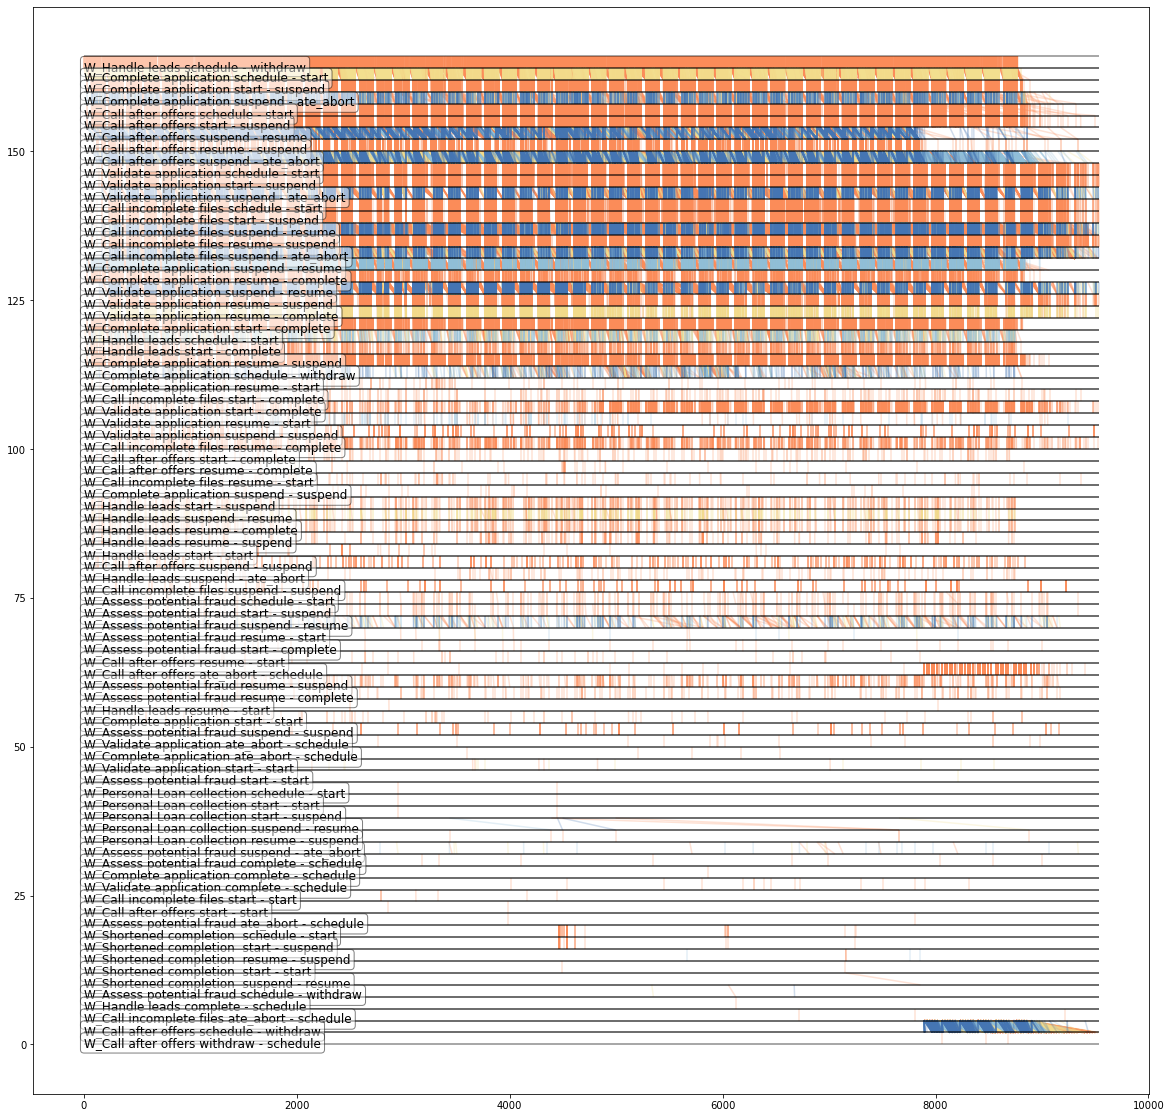

In [21]:
bpi.classify(bpi.pf, bpi.classify_duration_hist, args=[4], metric='duration', inplace=True)
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[20,20])
bpi.plot_performance_spectrum(class_colors, ax)

# Old loading

In [48]:
start_times = []
end_times = []
concept_names = []
case_id = []
resource = []
for name, segment in filtered.groupby(['case_id', 'concept:name']):
    for i in range(len(segment)):
        if segment.iloc[i]['lifecycle:transition'] == 'start' or segment.iloc[i]['lifecycle:transition'] == 'resume':
            start_times.append(segment.iloc[i]['time:timestamp'])
            end_times.append(segment.iloc[i+1]['time:timestamp'])
            resource.append(segment.iloc[i]['org:resource'])
            case_id.append(name[0])
            if segment.iloc[i+1]['lifecycle:transition'] == 'complete':
                concept_names.append(segment.iloc[i]['concept:name'] + "\n start/resume work \u2192 completed")
                # We are done with this segment.
                break
            else:
                concept_names.append(segment.iloc[i]['concept:name'] + "\n start/resume work \u2192 shelved")
        elif segment.iloc[i]['lifecycle:transition'] == 'ate_abort':
            start_times.append(segment.iloc[i-1]['time:timestamp'])
            end_times.append(segment.iloc[i]['time:timestamp'])
            resource.append(segment.iloc[i]['org:resource'])
            concept_names.append(segment.iloc[i]['concept:name'] + "\n shelved \u2192 abborted")
            case_id.append(name[0])
        elif i == len(segment) - 1:
            # The case does not have an end, its suspended forever.
            print(name)
        elif segment.iloc[i]['lifecycle:transition'] == 'suspend' and segment.iloc[i+1]['lifecycle:transition'] == 'resume':
            start_times.append(segment.iloc[i]['time:timestamp'])
            end_times.append(segment.iloc[i+1]['time:timestamp'])
            resource.append((segment.iloc[i]['org:resource'], segment.iloc[i+1]['org:resource']))
            concept_names.append(segment.iloc[i]['concept:name'] + "\n shelved \u2192 resumed")
            case_id.append(name[0])

(0.0, 'W_Handle leads')
(1.0, 'W_Handle leads')
(2.0, 'W_Handle leads')
(4.0, 'W_Handle leads')
(5.0, 'W_Handle leads')
(6.0, 'W_Handle leads')
(7.0, 'W_Handle leads')
(8.0, 'W_Handle leads')
(9.0, 'W_Handle leads')
(10.0, 'W_Handle leads')
(11.0, 'W_Handle leads')
(12.0, 'W_Complete application')
(12.0, 'W_Handle leads')
(13.0, 'W_Handle leads')
(14.0, 'W_Handle leads')
(15.0, 'W_Handle leads')
(17.0, 'W_Handle leads')
(18.0, 'W_Handle leads')
(19.0, 'W_Handle leads')
(20.0, 'W_Handle leads')
(21.0, 'W_Handle leads')
(23.0, 'W_Handle leads')
(24.0, 'W_Handle leads')
(26.0, 'W_Handle leads')
(27.0, 'W_Handle leads')
(29.0, 'W_Handle leads')
(31.0, 'W_Handle leads')
(33.0, 'W_Handle leads')
(34.0, 'W_Handle leads')
(35.0, 'W_Handle leads')
(36.0, 'W_Handle leads')
(37.0, 'W_Handle leads')
(49.0, 'W_Handle leads')
(54.0, 'W_Handle leads')
(55.0, 'W_Handle leads')
(56.0, 'W_Handle leads')
(57.0, 'W_Handle leads')
(58.0, 'W_Handle leads')
(60.0, 'W_Handle leads')
(61.0, 'W_Handle leads')
(

(606.0, 'W_Handle leads')
(607.0, 'W_Handle leads')
(609.0, 'W_Handle leads')
(610.0, 'W_Handle leads')
(611.0, 'W_Handle leads')
(612.0, 'W_Handle leads')
(614.0, 'W_Handle leads')
(615.0, 'W_Handle leads')
(617.0, 'W_Handle leads')
(618.0, 'W_Handle leads')
(620.0, 'W_Handle leads')
(621.0, 'W_Handle leads')
(622.0, 'W_Handle leads')
(623.0, 'W_Handle leads')
(625.0, 'W_Handle leads')
(626.0, 'W_Handle leads')
(627.0, 'W_Handle leads')
(628.0, 'W_Handle leads')
(629.0, 'W_Handle leads')
(631.0, 'W_Handle leads')
(632.0, 'W_Handle leads')
(634.0, 'W_Handle leads')
(635.0, 'W_Handle leads')
(636.0, 'W_Handle leads')
(637.0, 'W_Complete application')
(637.0, 'W_Handle leads')
(638.0, 'W_Handle leads')
(639.0, 'W_Handle leads')
(640.0, 'W_Handle leads')
(641.0, 'W_Handle leads')
(642.0, 'W_Handle leads')
(643.0, 'W_Handle leads')
(644.0, 'W_Handle leads')
(645.0, 'W_Handle leads')
(646.0, 'W_Handle leads')
(647.0, 'W_Handle leads')
(648.0, 'W_Handle leads')
(649.0, 'W_Handle leads')
(667

(1241.0, 'W_Handle leads')
(1244.0, 'W_Handle leads')
(1248.0, 'W_Handle leads')
(1250.0, 'W_Complete application')
(1250.0, 'W_Handle leads')
(1253.0, 'W_Handle leads')
(1254.0, 'W_Handle leads')
(1255.0, 'W_Handle leads')
(1256.0, 'W_Handle leads')
(1258.0, 'W_Handle leads')
(1264.0, 'W_Handle leads')
(1267.0, 'W_Handle leads')
(1272.0, 'W_Handle leads')
(1273.0, 'W_Handle leads')
(1275.0, 'W_Handle leads')
(1276.0, 'W_Handle leads')
(1277.0, 'W_Complete application')
(1277.0, 'W_Handle leads')
(1279.0, 'W_Handle leads')
(1282.0, 'W_Handle leads')
(1283.0, 'W_Complete application')
(1283.0, 'W_Handle leads')
(1284.0, 'W_Handle leads')
(1287.0, 'W_Handle leads')
(1288.0, 'W_Handle leads')
(1289.0, 'W_Handle leads')
(1290.0, 'W_Handle leads')
(1295.0, 'W_Handle leads')
(1296.0, 'W_Complete application')
(1296.0, 'W_Handle leads')
(1298.0, 'W_Handle leads')
(1300.0, 'W_Handle leads')
(1301.0, 'W_Handle leads')
(1302.0, 'W_Handle leads')
(1303.0, 'W_Handle leads')
(1304.0, 'W_Handle lead

(1766.0, 'W_Handle leads')
(1770.0, 'W_Handle leads')
(1772.0, 'W_Handle leads')
(1773.0, 'W_Handle leads')
(1774.0, 'W_Handle leads')
(1775.0, 'W_Handle leads')
(1777.0, 'W_Handle leads')
(1779.0, 'W_Handle leads')
(1780.0, 'W_Handle leads')
(1787.0, 'W_Handle leads')
(1788.0, 'W_Handle leads')
(1789.0, 'W_Handle leads')
(1791.0, 'W_Handle leads')
(1794.0, 'W_Handle leads')
(1798.0, 'W_Handle leads')
(1800.0, 'W_Handle leads')
(1806.0, 'W_Handle leads')
(1808.0, 'W_Handle leads')
(1810.0, 'W_Handle leads')
(1812.0, 'W_Handle leads')
(1813.0, 'W_Handle leads')
(1814.0, 'W_Handle leads')
(1815.0, 'W_Handle leads')
(1816.0, 'W_Handle leads')
(1820.0, 'W_Handle leads')
(1821.0, 'W_Handle leads')
(1822.0, 'W_Handle leads')
(1825.0, 'W_Handle leads')
(1826.0, 'W_Handle leads')
(1830.0, 'W_Handle leads')
(1832.0, 'W_Handle leads')
(1834.0, 'W_Handle leads')
(1835.0, 'W_Handle leads')
(1837.0, 'W_Handle leads')
(1841.0, 'W_Handle leads')
(1844.0, 'W_Handle leads')
(1846.0, 'W_Handle leads')
(

(2283.0, 'W_Handle leads')
(2284.0, 'W_Complete application')
(2284.0, 'W_Handle leads')
(2286.0, 'W_Handle leads')
(2289.0, 'W_Handle leads')
(2291.0, 'W_Handle leads')
(2294.0, 'W_Complete application')
(2294.0, 'W_Handle leads')
(2296.0, 'W_Handle leads')
(2297.0, 'W_Handle leads')
(2299.0, 'W_Handle leads')
(2301.0, 'W_Handle leads')
(2302.0, 'W_Handle leads')
(2303.0, 'W_Handle leads')
(2304.0, 'W_Handle leads')
(2306.0, 'W_Handle leads')
(2310.0, 'W_Handle leads')
(2311.0, 'W_Handle leads')
(2316.0, 'W_Handle leads')
(2318.0, 'W_Handle leads')
(2320.0, 'W_Handle leads')
(2321.0, 'W_Handle leads')
(2322.0, 'W_Handle leads')
(2323.0, 'W_Handle leads')
(2326.0, 'W_Handle leads')
(2327.0, 'W_Handle leads')
(2329.0, 'W_Complete application')
(2329.0, 'W_Handle leads')
(2331.0, 'W_Handle leads')
(2335.0, 'W_Handle leads')
(2337.0, 'W_Handle leads')
(2340.0, 'W_Handle leads')
(2341.0, 'W_Handle leads')
(2342.0, 'W_Handle leads')
(2343.0, 'W_Handle leads')
(2344.0, 'W_Handle leads')
(234

(2760.0, 'W_Handle leads')
(2762.0, 'W_Handle leads')
(2763.0, 'W_Complete application')
(2763.0, 'W_Handle leads')
(2764.0, 'W_Handle leads')
(2765.0, 'W_Handle leads')
(2766.0, 'W_Complete application')
(2766.0, 'W_Handle leads')
(2767.0, 'W_Handle leads')
(2768.0, 'W_Handle leads')
(2770.0, 'W_Handle leads')
(2771.0, 'W_Handle leads')
(2772.0, 'W_Handle leads')
(2773.0, 'W_Handle leads')
(2774.0, 'W_Handle leads')
(2775.0, 'W_Handle leads')
(2776.0, 'W_Handle leads')
(2777.0, 'W_Handle leads')
(2778.0, 'W_Handle leads')
(2779.0, 'W_Handle leads')
(2780.0, 'W_Handle leads')
(2781.0, 'W_Handle leads')
(2782.0, 'W_Handle leads')
(2783.0, 'W_Handle leads')
(2784.0, 'W_Complete application')
(2784.0, 'W_Handle leads')
(2785.0, 'W_Complete application')
(2785.0, 'W_Handle leads')
(2786.0, 'W_Handle leads')
(2787.0, 'W_Handle leads')
(2788.0, 'W_Handle leads')
(2789.0, 'W_Handle leads')
(2790.0, 'W_Handle leads')
(2791.0, 'W_Handle leads')
(2792.0, 'W_Handle leads')
(2793.0, 'W_Handle lead

(3235.0, 'W_Handle leads')
(3236.0, 'W_Handle leads')
(3237.0, 'W_Handle leads')
(3238.0, 'W_Handle leads')
(3240.0, 'W_Handle leads')
(3241.0, 'W_Handle leads')
(3242.0, 'W_Handle leads')
(3243.0, 'W_Complete application')
(3243.0, 'W_Handle leads')
(3245.0, 'W_Handle leads')
(3246.0, 'W_Handle leads')
(3247.0, 'W_Handle leads')
(3249.0, 'W_Handle leads')
(3250.0, 'W_Handle leads')
(3251.0, 'W_Handle leads')
(3254.0, 'W_Handle leads')
(3255.0, 'W_Complete application')
(3255.0, 'W_Handle leads')
(3256.0, 'W_Handle leads')
(3258.0, 'W_Handle leads')
(3259.0, 'W_Handle leads')
(3260.0, 'W_Handle leads')
(3261.0, 'W_Handle leads')
(3262.0, 'W_Handle leads')
(3263.0, 'W_Complete application')
(3263.0, 'W_Handle leads')
(3286.0, 'W_Handle leads')
(3287.0, 'W_Complete application')
(3287.0, 'W_Handle leads')
(3288.0, 'W_Handle leads')
(3290.0, 'W_Handle leads')
(3291.0, 'W_Handle leads')
(3293.0, 'W_Handle leads')
(3294.0, 'W_Handle leads')
(3295.0, 'W_Handle leads')
(3296.0, 'W_Handle lead

(3734.0, 'W_Handle leads')
(3735.0, 'W_Handle leads')
(3736.0, 'W_Handle leads')
(3741.0, 'W_Handle leads')
(3742.0, 'W_Complete application')
(3742.0, 'W_Handle leads')
(3743.0, 'W_Handle leads')
(3758.0, 'W_Handle leads')
(3759.0, 'W_Handle leads')
(3760.0, 'W_Handle leads')
(3762.0, 'W_Handle leads')
(3763.0, 'W_Complete application')
(3763.0, 'W_Handle leads')
(3765.0, 'W_Handle leads')
(3767.0, 'W_Complete application')
(3767.0, 'W_Handle leads')
(3771.0, 'W_Handle leads')
(3772.0, 'W_Handle leads')
(3775.0, 'W_Complete application')
(3775.0, 'W_Handle leads')
(3777.0, 'W_Handle leads')
(3778.0, 'W_Handle leads')
(3779.0, 'W_Handle leads')
(3782.0, 'W_Handle leads')
(3785.0, 'W_Handle leads')
(3786.0, 'W_Handle leads')
(3787.0, 'W_Handle leads')
(3788.0, 'W_Handle leads')
(3791.0, 'W_Handle leads')
(3794.0, 'W_Handle leads')
(3796.0, 'W_Handle leads')
(3799.0, 'W_Handle leads')
(3801.0, 'W_Handle leads')
(3802.0, 'W_Complete application')
(3802.0, 'W_Handle leads')
(3803.0, 'W_Han

(4264.0, 'W_Handle leads')
(4265.0, 'W_Handle leads')
(4267.0, 'W_Handle leads')
(4268.0, 'W_Handle leads')
(4269.0, 'W_Handle leads')
(4271.0, 'W_Handle leads')
(4272.0, 'W_Handle leads')
(4273.0, 'W_Handle leads')
(4274.0, 'W_Handle leads')
(4276.0, 'W_Handle leads')
(4277.0, 'W_Handle leads')
(4278.0, 'W_Handle leads')
(4279.0, 'W_Handle leads')
(4280.0, 'W_Handle leads')
(4281.0, 'W_Handle leads')
(4283.0, 'W_Handle leads')
(4286.0, 'W_Handle leads')
(4287.0, 'W_Handle leads')
(4288.0, 'W_Handle leads')
(4289.0, 'W_Complete application')
(4289.0, 'W_Handle leads')
(4290.0, 'W_Handle leads')
(4292.0, 'W_Handle leads')
(4295.0, 'W_Handle leads')
(4298.0, 'W_Handle leads')
(4300.0, 'W_Handle leads')
(4303.0, 'W_Handle leads')
(4304.0, 'W_Handle leads')
(4307.0, 'W_Handle leads')
(4309.0, 'W_Handle leads')
(4314.0, 'W_Handle leads')
(4315.0, 'W_Handle leads')
(4320.0, 'W_Handle leads')
(4322.0, 'W_Handle leads')
(4324.0, 'W_Handle leads')
(4325.0, 'W_Handle leads')
(4327.0, 'W_Handle l

(4803.0, 'W_Handle leads')
(4804.0, 'W_Handle leads')
(4805.0, 'W_Handle leads')
(4807.0, 'W_Handle leads')
(4808.0, 'W_Handle leads')
(4809.0, 'W_Handle leads')
(4810.0, 'W_Handle leads')
(4811.0, 'W_Handle leads')
(4816.0, 'W_Handle leads')
(4820.0, 'W_Handle leads')
(4823.0, 'W_Handle leads')
(4829.0, 'W_Handle leads')
(4830.0, 'W_Handle leads')
(4831.0, 'W_Handle leads')
(4832.0, 'W_Handle leads')
(4834.0, 'W_Handle leads')
(4836.0, 'W_Handle leads')
(4837.0, 'W_Handle leads')
(4839.0, 'W_Handle leads')
(4840.0, 'W_Handle leads')
(4841.0, 'W_Handle leads')
(4842.0, 'W_Handle leads')
(4844.0, 'W_Handle leads')
(4845.0, 'W_Handle leads')
(4850.0, 'W_Handle leads')
(4851.0, 'W_Handle leads')
(4853.0, 'W_Handle leads')
(4855.0, 'W_Handle leads')
(4856.0, 'W_Handle leads')
(4860.0, 'W_Handle leads')
(4861.0, 'W_Complete application')
(4861.0, 'W_Handle leads')
(4863.0, 'W_Handle leads')
(4864.0, 'W_Handle leads')
(4865.0, 'W_Handle leads')
(4867.0, 'W_Handle leads')
(4869.0, 'W_Handle l

(5279.0, 'W_Handle leads')
(5280.0, 'W_Handle leads')
(5282.0, 'W_Handle leads')
(5283.0, 'W_Handle leads')
(5284.0, 'W_Handle leads')
(5286.0, 'W_Handle leads')
(5287.0, 'W_Handle leads')
(5288.0, 'W_Handle leads')
(5289.0, 'W_Handle leads')
(5290.0, 'W_Handle leads')
(5293.0, 'W_Handle leads')
(5299.0, 'W_Handle leads')
(5300.0, 'W_Handle leads')
(5305.0, 'W_Handle leads')
(5306.0, 'W_Handle leads')
(5307.0, 'W_Handle leads')
(5308.0, 'W_Handle leads')
(5313.0, 'W_Complete application')
(5313.0, 'W_Handle leads')
(5314.0, 'W_Handle leads')
(5315.0, 'W_Handle leads')
(5316.0, 'W_Handle leads')
(5317.0, 'W_Handle leads')
(5318.0, 'W_Handle leads')
(5319.0, 'W_Complete application')
(5319.0, 'W_Handle leads')
(5326.0, 'W_Complete application')
(5326.0, 'W_Handle leads')
(5328.0, 'W_Handle leads')
(5331.0, 'W_Handle leads')
(5332.0, 'W_Handle leads')
(5333.0, 'W_Handle leads')
(5334.0, 'W_Handle leads')
(5335.0, 'W_Handle leads')
(5338.0, 'W_Handle leads')
(5339.0, 'W_Handle leads')
(534

(5780.0, 'W_Complete application')
(5780.0, 'W_Handle leads')
(5784.0, 'W_Handle leads')
(5785.0, 'W_Handle leads')
(5786.0, 'W_Handle leads')
(5788.0, 'W_Handle leads')
(5789.0, 'W_Handle leads')
(5790.0, 'W_Handle leads')
(5800.0, 'W_Handle leads')
(5803.0, 'W_Handle leads')
(5804.0, 'W_Handle leads')
(5811.0, 'W_Handle leads')
(5812.0, 'W_Handle leads')
(5813.0, 'W_Handle leads')
(5814.0, 'W_Complete application')
(5814.0, 'W_Handle leads')
(5817.0, 'W_Handle leads')
(5819.0, 'W_Handle leads')
(5820.0, 'W_Handle leads')
(5821.0, 'W_Handle leads')
(5823.0, 'W_Complete application')
(5823.0, 'W_Handle leads')
(5824.0, 'W_Handle leads')
(5825.0, 'W_Handle leads')
(5826.0, 'W_Handle leads')
(5827.0, 'W_Handle leads')
(5829.0, 'W_Handle leads')
(5831.0, 'W_Handle leads')
(5834.0, 'W_Handle leads')
(5835.0, 'W_Handle leads')
(5836.0, 'W_Handle leads')
(5837.0, 'W_Handle leads')
(5838.0, 'W_Handle leads')
(5839.0, 'W_Handle leads')
(5841.0, 'W_Handle leads')
(5842.0, 'W_Handle leads')
(584

(6317.0, 'W_Handle leads')
(6319.0, 'W_Handle leads')
(6323.0, 'W_Handle leads')
(6324.0, 'W_Handle leads')
(6325.0, 'W_Handle leads')
(6326.0, 'W_Handle leads')
(6327.0, 'W_Handle leads')
(6329.0, 'W_Handle leads')
(6330.0, 'W_Handle leads')
(6332.0, 'W_Handle leads')
(6333.0, 'W_Handle leads')
(6334.0, 'W_Handle leads')
(6335.0, 'W_Handle leads')
(6336.0, 'W_Handle leads')
(6337.0, 'W_Handle leads')
(6338.0, 'W_Handle leads')
(6339.0, 'W_Handle leads')
(6340.0, 'W_Handle leads')
(6341.0, 'W_Handle leads')
(6348.0, 'W_Handle leads')
(6350.0, 'W_Handle leads')
(6351.0, 'W_Handle leads')
(6352.0, 'W_Handle leads')
(6355.0, 'W_Handle leads')
(6357.0, 'W_Handle leads')
(6361.0, 'W_Handle leads')
(6366.0, 'W_Handle leads')
(6368.0, 'W_Handle leads')
(6369.0, 'W_Handle leads')
(6371.0, 'W_Handle leads')
(6375.0, 'W_Handle leads')
(6378.0, 'W_Handle leads')
(6379.0, 'W_Handle leads')
(6380.0, 'W_Handle leads')
(6381.0, 'W_Handle leads')
(6384.0, 'W_Handle leads')
(6387.0, 'W_Handle leads')
(

(6846.0, 'W_Handle leads')
(6849.0, 'W_Handle leads')
(6852.0, 'W_Handle leads')
(6854.0, 'W_Handle leads')
(6855.0, 'W_Handle leads')
(6859.0, 'W_Handle leads')
(6860.0, 'W_Handle leads')
(6862.0, 'W_Handle leads')
(6863.0, 'W_Handle leads')
(6864.0, 'W_Handle leads')
(6866.0, 'W_Handle leads')
(6867.0, 'W_Handle leads')
(6868.0, 'W_Handle leads')
(6869.0, 'W_Handle leads')
(6870.0, 'W_Handle leads')
(6871.0, 'W_Handle leads')
(6872.0, 'W_Handle leads')
(6873.0, 'W_Handle leads')
(6881.0, 'W_Handle leads')
(6882.0, 'W_Handle leads')
(6888.0, 'W_Handle leads')
(6892.0, 'W_Handle leads')
(6893.0, 'W_Handle leads')
(6894.0, 'W_Handle leads')
(6897.0, 'W_Handle leads')
(6898.0, 'W_Handle leads')
(6899.0, 'W_Handle leads')
(6900.0, 'W_Handle leads')
(6907.0, 'W_Handle leads')
(6908.0, 'W_Handle leads')
(6910.0, 'W_Handle leads')
(6911.0, 'W_Handle leads')
(6914.0, 'W_Handle leads')
(6917.0, 'W_Handle leads')
(6919.0, 'W_Handle leads')
(6920.0, 'W_Handle leads')
(6921.0, 'W_Handle leads')
(

(7383.0, 'W_Handle leads')
(7387.0, 'W_Handle leads')
(7389.0, 'W_Handle leads')
(7390.0, 'W_Complete application')
(7390.0, 'W_Handle leads')
(7391.0, 'W_Handle leads')
(7397.0, 'W_Handle leads')
(7398.0, 'W_Handle leads')
(7399.0, 'W_Complete application')
(7399.0, 'W_Handle leads')
(7401.0, 'W_Handle leads')
(7402.0, 'W_Handle leads')
(7403.0, 'W_Handle leads')
(7404.0, 'W_Handle leads')
(7405.0, 'W_Handle leads')
(7407.0, 'W_Handle leads')
(7408.0, 'W_Handle leads')
(7409.0, 'W_Handle leads')
(7410.0, 'W_Handle leads')
(7411.0, 'W_Handle leads')
(7413.0, 'W_Handle leads')
(7414.0, 'W_Handle leads')
(7415.0, 'W_Handle leads')
(7416.0, 'W_Handle leads')
(7417.0, 'W_Handle leads')
(7418.0, 'W_Handle leads')
(7419.0, 'W_Handle leads')
(7420.0, 'W_Handle leads')
(7421.0, 'W_Handle leads')
(7423.0, 'W_Complete application')
(7423.0, 'W_Handle leads')
(7424.0, 'W_Handle leads')
(7425.0, 'W_Handle leads')
(7426.0, 'W_Handle leads')
(7431.0, 'W_Handle leads')
(7433.0, 'W_Handle leads')
(743

(7876.0, 'W_Handle leads')
(7880.0, 'W_Handle leads')
(7881.0, 'W_Handle leads')
(7883.0, 'W_Handle leads')
(7884.0, 'W_Handle leads')
(7886.0, 'W_Handle leads')
(7887.0, 'W_Handle leads')
(7889.0, 'W_Handle leads')
(7890.0, 'W_Handle leads')
(7893.0, 'W_Handle leads')
(7895.0, 'W_Handle leads')
(7897.0, 'W_Handle leads')
(7902.0, 'W_Handle leads')
(7904.0, 'W_Handle leads')
(7905.0, 'W_Handle leads')
(7908.0, 'W_Handle leads')
(7909.0, 'W_Handle leads')
(7914.0, 'W_Handle leads')
(7915.0, 'W_Handle leads')
(7918.0, 'W_Handle leads')
(7919.0, 'W_Handle leads')
(7920.0, 'W_Handle leads')
(7923.0, 'W_Handle leads')
(7924.0, 'W_Handle leads')
(7926.0, 'W_Handle leads')
(7927.0, 'W_Handle leads')
(7928.0, 'W_Handle leads')
(7929.0, 'W_Handle leads')
(7930.0, 'W_Handle leads')
(7931.0, 'W_Handle leads')
(7933.0, 'W_Handle leads')
(7934.0, 'W_Handle leads')
(7935.0, 'W_Handle leads')
(7936.0, 'W_Handle leads')
(7938.0, 'W_Handle leads')
(7939.0, 'W_Handle leads')
(7940.0, 'W_Complete applica

(8423.0, 'W_Handle leads')
(8426.0, 'W_Handle leads')
(8429.0, 'W_Handle leads')
(8435.0, 'W_Handle leads')
(8436.0, 'W_Handle leads')
(8439.0, 'W_Handle leads')
(8440.0, 'W_Handle leads')
(8442.0, 'W_Handle leads')
(8443.0, 'W_Handle leads')
(8448.0, 'W_Handle leads')
(8449.0, 'W_Handle leads')
(8451.0, 'W_Handle leads')
(8452.0, 'W_Handle leads')
(8453.0, 'W_Handle leads')
(8454.0, 'W_Handle leads')
(8457.0, 'W_Handle leads')
(8459.0, 'W_Handle leads')
(8460.0, 'W_Handle leads')
(8461.0, 'W_Handle leads')
(8462.0, 'W_Handle leads')
(8463.0, 'W_Handle leads')
(8466.0, 'W_Handle leads')
(8467.0, 'W_Handle leads')
(8468.0, 'W_Handle leads')
(8469.0, 'W_Handle leads')
(8470.0, 'W_Handle leads')
(8472.0, 'W_Handle leads')
(8474.0, 'W_Handle leads')
(8476.0, 'W_Handle leads')
(8477.0, 'W_Handle leads')
(8478.0, 'W_Handle leads')
(8479.0, 'W_Handle leads')
(8481.0, 'W_Handle leads')
(8484.0, 'W_Handle leads')
(8485.0, 'W_Handle leads')
(8488.0, 'W_Handle leads')
(8489.0, 'W_Handle leads')
(

(8943.0, 'W_Handle leads')
(8944.0, 'W_Handle leads')
(8951.0, 'W_Handle leads')
(8952.0, 'W_Handle leads')
(8954.0, 'W_Handle leads')
(8957.0, 'W_Handle leads')
(8958.0, 'W_Handle leads')
(8960.0, 'W_Handle leads')
(8962.0, 'W_Handle leads')
(8963.0, 'W_Handle leads')
(8965.0, 'W_Handle leads')
(8966.0, 'W_Handle leads')
(8967.0, 'W_Handle leads')
(8968.0, 'W_Handle leads')
(8969.0, 'W_Handle leads')
(8970.0, 'W_Handle leads')
(8971.0, 'W_Handle leads')
(8972.0, 'W_Handle leads')
(8973.0, 'W_Handle leads')
(8974.0, 'W_Handle leads')
(8975.0, 'W_Handle leads')
(8976.0, 'W_Handle leads')
(8977.0, 'W_Handle leads')
(8978.0, 'W_Handle leads')
(8979.0, 'W_Handle leads')
(8980.0, 'W_Handle leads')
(8982.0, 'W_Handle leads')
(8987.0, 'W_Handle leads')
(8995.0, 'W_Handle leads')
(8997.0, 'W_Handle leads')
(8999.0, 'W_Handle leads')
(9005.0, 'W_Handle leads')
(9007.0, 'W_Handle leads')
(9009.0, 'W_Handle leads')
(9010.0, 'W_Handle leads')
(9014.0, 'W_Handle leads')
(9019.0, 'W_Handle leads')
(

(9543.0, 'W_Handle leads')
(9545.0, 'W_Handle leads')
(9546.0, 'W_Handle leads')
(9547.0, 'W_Handle leads')
(9549.0, 'W_Handle leads')
(9550.0, 'W_Handle leads')
(9551.0, 'W_Handle leads')
(9552.0, 'W_Handle leads')
(9553.0, 'W_Handle leads')
(9554.0, 'W_Handle leads')
(9555.0, 'W_Handle leads')
(9557.0, 'W_Handle leads')
(9558.0, 'W_Handle leads')
(9559.0, 'W_Handle leads')
(9560.0, 'W_Handle leads')
(9561.0, 'W_Handle leads')
(9562.0, 'W_Handle leads')
(9563.0, 'W_Handle leads')
(9564.0, 'W_Handle leads')
(9571.0, 'W_Handle leads')
(9573.0, 'W_Handle leads')
(9577.0, 'W_Handle leads')
(9578.0, 'W_Handle leads')
(9579.0, 'W_Handle leads')
(9580.0, 'W_Handle leads')
(9581.0, 'W_Handle leads')
(9582.0, 'W_Handle leads')
(9584.0, 'W_Handle leads')
(9586.0, 'W_Handle leads')
(9587.0, 'W_Handle leads')
(9588.0, 'W_Handle leads')
(9589.0, 'W_Handle leads')
(9592.0, 'W_Handle leads')
(9596.0, 'W_Handle leads')
(9598.0, 'W_Handle leads')
(9603.0, 'W_Handle leads')
(9605.0, 'W_Handle leads')
(

(10077.0, 'W_Handle leads')
(10078.0, 'W_Handle leads')
(10079.0, 'W_Handle leads')
(10080.0, 'W_Handle leads')
(10082.0, 'W_Handle leads')
(10083.0, 'W_Handle leads')
(10084.0, 'W_Handle leads')
(10085.0, 'W_Handle leads')
(10086.0, 'W_Handle leads')
(10087.0, 'W_Handle leads')
(10088.0, 'W_Handle leads')
(10091.0, 'W_Handle leads')
(10094.0, 'W_Handle leads')
(10097.0, 'W_Handle leads')
(10098.0, 'W_Handle leads')
(10099.0, 'W_Handle leads')
(10105.0, 'W_Handle leads')
(10108.0, 'W_Handle leads')
(10111.0, 'W_Handle leads')
(10114.0, 'W_Handle leads')
(10115.0, 'W_Handle leads')
(10116.0, 'W_Handle leads')
(10117.0, 'W_Handle leads')
(10118.0, 'W_Handle leads')
(10119.0, 'W_Handle leads')
(10121.0, 'W_Handle leads')
(10123.0, 'W_Complete application')
(10123.0, 'W_Handle leads')
(10125.0, 'W_Handle leads')
(10128.0, 'W_Handle leads')
(10130.0, 'W_Handle leads')
(10131.0, 'W_Handle leads')
(10132.0, 'W_Handle leads')
(10133.0, 'W_Handle leads')
(10134.0, 'W_Complete application')
(101

(10605.0, 'W_Handle leads')
(10606.0, 'W_Handle leads')
(10607.0, 'W_Handle leads')
(10608.0, 'W_Handle leads')
(10609.0, 'W_Handle leads')
(10610.0, 'W_Handle leads')
(10611.0, 'W_Handle leads')
(10612.0, 'W_Handle leads')
(10613.0, 'W_Complete application')
(10613.0, 'W_Handle leads')
(10614.0, 'W_Handle leads')
(10615.0, 'W_Handle leads')
(10616.0, 'W_Handle leads')
(10617.0, 'W_Handle leads')
(10618.0, 'W_Handle leads')
(10621.0, 'W_Handle leads')
(10622.0, 'W_Handle leads')
(10623.0, 'W_Handle leads')
(10625.0, 'W_Handle leads')
(10627.0, 'W_Handle leads')
(10628.0, 'W_Handle leads')
(10629.0, 'W_Handle leads')
(10630.0, 'W_Handle leads')
(10631.0, 'W_Handle leads')
(10632.0, 'W_Handle leads')
(10633.0, 'W_Handle leads')
(10634.0, 'W_Handle leads')
(10636.0, 'W_Handle leads')
(10637.0, 'W_Handle leads')
(10638.0, 'W_Handle leads')
(10639.0, 'W_Handle leads')
(10641.0, 'W_Handle leads')
(10644.0, 'W_Handle leads')
(10652.0, 'W_Handle leads')
(10655.0, 'W_Handle leads')
(10658.0, 'W

(11115.0, 'W_Handle leads')
(11116.0, 'W_Handle leads')
(11117.0, 'W_Handle leads')
(11119.0, 'W_Handle leads')
(11120.0, 'W_Handle leads')
(11134.0, 'W_Handle leads')
(11141.0, 'W_Handle leads')
(11154.0, 'W_Handle leads')
(11157.0, 'W_Handle leads')
(11159.0, 'W_Handle leads')
(11160.0, 'W_Handle leads')
(11161.0, 'W_Handle leads')
(11162.0, 'W_Handle leads')
(11168.0, 'W_Handle leads')
(11169.0, 'W_Handle leads')
(11179.0, 'W_Handle leads')
(11180.0, 'W_Handle leads')
(11181.0, 'W_Handle leads')
(11183.0, 'W_Handle leads')
(11184.0, 'W_Handle leads')
(11185.0, 'W_Handle leads')
(11187.0, 'W_Handle leads')
(11190.0, 'W_Handle leads')
(11191.0, 'W_Handle leads')
(11195.0, 'W_Handle leads')
(11197.0, 'W_Handle leads')
(11199.0, 'W_Handle leads')
(11201.0, 'W_Handle leads')
(11202.0, 'W_Handle leads')
(11204.0, 'W_Handle leads')
(11205.0, 'W_Handle leads')
(11208.0, 'W_Handle leads')
(11210.0, 'W_Handle leads')
(11212.0, 'W_Handle leads')
(11214.0, 'W_Handle leads')
(11218.0, 'W_Handle 

(11685.0, 'W_Handle leads')
(11686.0, 'W_Handle leads')
(11687.0, 'W_Handle leads')
(11688.0, 'W_Handle leads')
(11689.0, 'W_Handle leads')
(11690.0, 'W_Handle leads')
(11691.0, 'W_Handle leads')
(11692.0, 'W_Handle leads')
(11693.0, 'W_Handle leads')
(11695.0, 'W_Handle leads')
(11697.0, 'W_Handle leads')
(11698.0, 'W_Handle leads')
(11700.0, 'W_Handle leads')
(11702.0, 'W_Handle leads')
(11705.0, 'W_Handle leads')
(11706.0, 'W_Handle leads')
(11707.0, 'W_Handle leads')
(11709.0, 'W_Handle leads')
(11711.0, 'W_Handle leads')
(11712.0, 'W_Handle leads')
(11713.0, 'W_Handle leads')
(11714.0, 'W_Handle leads')
(11715.0, 'W_Handle leads')
(11716.0, 'W_Handle leads')
(11718.0, 'W_Handle leads')
(11720.0, 'W_Complete application')
(11720.0, 'W_Handle leads')
(11721.0, 'W_Handle leads')
(11722.0, 'W_Handle leads')
(11723.0, 'W_Handle leads')
(11724.0, 'W_Handle leads')
(11725.0, 'W_Complete application')
(11725.0, 'W_Handle leads')
(11727.0, 'W_Handle leads')
(11730.0, 'W_Complete applicatio

(12223.0, 'W_Handle leads')
(12224.0, 'W_Complete application')
(12226.0, 'W_Handle leads')
(12229.0, 'W_Handle leads')
(12230.0, 'W_Complete application')
(12230.0, 'W_Handle leads')
(12231.0, 'W_Handle leads')
(12237.0, 'W_Handle leads')
(12241.0, 'W_Handle leads')
(12244.0, 'W_Handle leads')
(12245.0, 'W_Handle leads')
(12248.0, 'W_Handle leads')
(12251.0, 'W_Handle leads')
(12252.0, 'W_Handle leads')
(12254.0, 'W_Handle leads')
(12257.0, 'W_Handle leads')
(12265.0, 'W_Handle leads')
(12266.0, 'W_Handle leads')
(12267.0, 'W_Handle leads')
(12268.0, 'W_Handle leads')
(12269.0, 'W_Handle leads')
(12271.0, 'W_Handle leads')
(12272.0, 'W_Handle leads')
(12273.0, 'W_Handle leads')
(12274.0, 'W_Handle leads')
(12276.0, 'W_Handle leads')
(12277.0, 'W_Handle leads')
(12278.0, 'W_Handle leads')
(12279.0, 'W_Handle leads')
(12280.0, 'W_Handle leads')
(12282.0, 'W_Complete application')
(12282.0, 'W_Handle leads')
(12283.0, 'W_Handle leads')
(12284.0, 'W_Handle leads')
(12285.0, 'W_Handle lead

(12703.0, 'W_Handle leads')
(12704.0, 'W_Handle leads')
(12705.0, 'W_Complete application')
(12705.0, 'W_Handle leads')
(12707.0, 'W_Handle leads')
(12711.0, 'W_Handle leads')
(12717.0, 'W_Handle leads')
(12718.0, 'W_Handle leads')
(12720.0, 'W_Complete application')
(12720.0, 'W_Handle leads')
(12724.0, 'W_Handle leads')
(12725.0, 'W_Handle leads')
(12729.0, 'W_Handle leads')
(12730.0, 'W_Handle leads')
(12734.0, 'W_Complete application')
(12734.0, 'W_Handle leads')
(12736.0, 'W_Handle leads')
(12738.0, 'W_Handle leads')
(12739.0, 'W_Handle leads')
(12740.0, 'W_Handle leads')
(12741.0, 'W_Handle leads')
(12742.0, 'W_Handle leads')
(12744.0, 'W_Complete application')
(12744.0, 'W_Handle leads')
(12746.0, 'W_Complete application')
(12746.0, 'W_Handle leads')
(12748.0, 'W_Handle leads')
(12752.0, 'W_Handle leads')
(12756.0, 'W_Handle leads')
(12757.0, 'W_Handle leads')
(12759.0, 'W_Handle leads')
(12760.0, 'W_Handle leads')
(12764.0, 'W_Handle leads')
(12765.0, 'W_Complete application')


(13164.0, 'W_Handle leads')
(13165.0, 'W_Handle leads')
(13166.0, 'W_Handle leads')
(13167.0, 'W_Handle leads')
(13169.0, 'W_Handle leads')
(13170.0, 'W_Handle leads')
(13173.0, 'W_Handle leads')
(13174.0, 'W_Handle leads')
(13179.0, 'W_Handle leads')
(13181.0, 'W_Handle leads')
(13183.0, 'W_Complete application')
(13183.0, 'W_Handle leads')
(13187.0, 'W_Handle leads')
(13188.0, 'W_Handle leads')
(13190.0, 'W_Handle leads')
(13192.0, 'W_Handle leads')
(13195.0, 'W_Handle leads')
(13198.0, 'W_Handle leads')
(13201.0, 'W_Handle leads')
(13208.0, 'W_Handle leads')
(13209.0, 'W_Handle leads')
(13210.0, 'W_Handle leads')
(13212.0, 'W_Handle leads')
(13213.0, 'W_Complete application')
(13213.0, 'W_Handle leads')
(13215.0, 'W_Handle leads')
(13218.0, 'W_Handle leads')
(13219.0, 'W_Handle leads')
(13220.0, 'W_Handle leads')
(13221.0, 'W_Handle leads')
(13222.0, 'W_Handle leads')
(13223.0, 'W_Handle leads')
(13226.0, 'W_Handle leads')
(13227.0, 'W_Handle leads')
(13228.0, 'W_Handle leads')
(132

(13677.0, 'W_Handle leads')
(13678.0, 'W_Handle leads')
(13680.0, 'W_Handle leads')
(13682.0, 'W_Handle leads')
(13684.0, 'W_Handle leads')
(13685.0, 'W_Handle leads')
(13689.0, 'W_Complete application')
(13691.0, 'W_Handle leads')
(13696.0, 'W_Handle leads')
(13697.0, 'W_Handle leads')
(13699.0, 'W_Handle leads')
(13702.0, 'W_Handle leads')
(13703.0, 'W_Handle leads')
(13704.0, 'W_Handle leads')
(13705.0, 'W_Complete application')
(13705.0, 'W_Handle leads')
(13706.0, 'W_Handle leads')
(13707.0, 'W_Handle leads')
(13708.0, 'W_Handle leads')
(13709.0, 'W_Handle leads')
(13710.0, 'W_Handle leads')
(13711.0, 'W_Complete application')
(13711.0, 'W_Handle leads')
(13712.0, 'W_Handle leads')
(13713.0, 'W_Handle leads')
(13714.0, 'W_Handle leads')
(13715.0, 'W_Handle leads')
(13717.0, 'W_Handle leads')
(13718.0, 'W_Handle leads')
(13720.0, 'W_Handle leads')
(13721.0, 'W_Handle leads')
(13722.0, 'W_Handle leads')
(13725.0, 'W_Handle leads')
(13727.0, 'W_Handle leads')
(13728.0, 'W_Handle lead

(14148.0, 'W_Handle leads')
(14151.0, 'W_Handle leads')
(14153.0, 'W_Handle leads')
(14155.0, 'W_Handle leads')
(14158.0, 'W_Handle leads')
(14161.0, 'W_Complete application')
(14161.0, 'W_Handle leads')
(14164.0, 'W_Handle leads')
(14167.0, 'W_Complete application')
(14167.0, 'W_Handle leads')
(14168.0, 'W_Handle leads')
(14169.0, 'W_Handle leads')
(14171.0, 'W_Handle leads')
(14173.0, 'W_Handle leads')
(14174.0, 'W_Handle leads')
(14179.0, 'W_Handle leads')
(14180.0, 'W_Handle leads')
(14182.0, 'W_Handle leads')
(14183.0, 'W_Complete application')
(14183.0, 'W_Handle leads')
(14184.0, 'W_Handle leads')
(14186.0, 'W_Complete application')
(14186.0, 'W_Handle leads')
(14189.0, 'W_Complete application')
(14189.0, 'W_Handle leads')
(14193.0, 'W_Handle leads')
(14194.0, 'W_Complete application')
(14194.0, 'W_Handle leads')
(14196.0, 'W_Handle leads')
(14197.0, 'W_Handle leads')
(14201.0, 'W_Handle leads')
(14202.0, 'W_Handle leads')
(14203.0, 'W_Handle leads')
(14204.0, 'W_Complete applic

(14539.0, 'W_Handle leads')
(14540.0, 'W_Complete application')
(14540.0, 'W_Handle leads')
(14540.0, 'W_Shortened completion ')
(14541.0, 'W_Complete application')
(14541.0, 'W_Handle leads')
(14542.0, 'W_Handle leads')
(14543.0, 'W_Complete application')
(14543.0, 'W_Handle leads')
(14544.0, 'W_Handle leads')
(14545.0, 'W_Handle leads')
(14546.0, 'W_Handle leads')
(14547.0, 'W_Shortened completion ')
(14549.0, 'W_Handle leads')
(14550.0, 'W_Complete application')
(14550.0, 'W_Handle leads')
(14550.0, 'W_Shortened completion ')
(14552.0, 'W_Handle leads')
(14553.0, 'W_Complete application')
(14553.0, 'W_Handle leads')
(14554.0, 'W_Handle leads')
(14554.0, 'W_Shortened completion ')
(14555.0, 'W_Complete application')
(14555.0, 'W_Handle leads')
(14555.0, 'W_Shortened completion ')
(14557.0, 'W_Handle leads')
(14558.0, 'W_Complete application')
(14558.0, 'W_Handle leads')
(14558.0, 'W_Shortened completion ')
(14559.0, 'W_Complete application')
(14559.0, 'W_Handle leads')
(14559.0, 'W_S

(14883.0, 'W_Handle leads')
(14883.0, 'W_Shortened completion ')
(14884.0, 'W_Handle leads')
(14886.0, 'W_Complete application')
(14886.0, 'W_Handle leads')
(14890.0, 'W_Handle leads')
(14891.0, 'W_Handle leads')
(14891.0, 'W_Shortened completion ')
(14892.0, 'W_Complete application')
(14894.0, 'W_Handle leads')
(14897.0, 'W_Handle leads')
(14898.0, 'W_Handle leads')
(14898.0, 'W_Shortened completion ')
(14899.0, 'W_Complete application')
(14899.0, 'W_Handle leads')
(14902.0, 'W_Handle leads')
(14904.0, 'W_Handle leads')
(14907.0, 'W_Handle leads')
(14907.0, 'W_Shortened completion ')
(14908.0, 'W_Handle leads')
(14908.0, 'W_Shortened completion ')
(14911.0, 'W_Handle leads')
(14913.0, 'W_Complete application')
(14913.0, 'W_Handle leads')
(14914.0, 'W_Handle leads')
(14915.0, 'W_Handle leads')
(14917.0, 'W_Handle leads')
(14917.0, 'W_Shortened completion ')
(14918.0, 'W_Handle leads')
(14918.0, 'W_Shortened completion ')
(14919.0, 'W_Handle leads')
(14922.0, 'W_Handle leads')
(14926.0,

(15319.0, 'W_Handle leads')
(15323.0, 'W_Handle leads')
(15326.0, 'W_Handle leads')
(15331.0, 'W_Handle leads')
(15334.0, 'W_Complete application')
(15334.0, 'W_Handle leads')
(15338.0, 'W_Handle leads')
(15338.0, 'W_Shortened completion ')
(15344.0, 'W_Handle leads')
(15349.0, 'W_Handle leads')
(15353.0, 'W_Handle leads')
(15356.0, 'W_Handle leads')
(15359.0, 'W_Handle leads')
(15360.0, 'W_Handle leads')
(15363.0, 'W_Handle leads')
(15365.0, 'W_Handle leads')
(15367.0, 'W_Handle leads')
(15369.0, 'W_Handle leads')
(15374.0, 'W_Handle leads')
(15375.0, 'W_Handle leads')
(15376.0, 'W_Handle leads')
(15377.0, 'W_Handle leads')
(15380.0, 'W_Handle leads')
(15383.0, 'W_Handle leads')
(15385.0, 'W_Handle leads')
(15388.0, 'W_Handle leads')
(15389.0, 'W_Handle leads')
(15392.0, 'W_Handle leads')
(15396.0, 'W_Handle leads')
(15398.0, 'W_Handle leads')
(15399.0, 'W_Handle leads')
(15400.0, 'W_Handle leads')
(15414.0, 'W_Handle leads')
(15415.0, 'W_Handle leads')
(15416.0, 'W_Handle leads')
(15

(15875.0, 'W_Handle leads')
(15877.0, 'W_Handle leads')
(15879.0, 'W_Handle leads')
(15881.0, 'W_Handle leads')
(15884.0, 'W_Handle leads')
(15886.0, 'W_Complete application')
(15886.0, 'W_Handle leads')
(15887.0, 'W_Handle leads')
(15889.0, 'W_Handle leads')
(15891.0, 'W_Handle leads')
(15894.0, 'W_Handle leads')
(15898.0, 'W_Handle leads')
(15899.0, 'W_Handle leads')
(15900.0, 'W_Handle leads')
(15901.0, 'W_Handle leads')
(15902.0, 'W_Handle leads')
(15904.0, 'W_Handle leads')
(15905.0, 'W_Handle leads')
(15906.0, 'W_Handle leads')
(15907.0, 'W_Handle leads')
(15908.0, 'W_Handle leads')
(15910.0, 'W_Handle leads')
(15913.0, 'W_Handle leads')
(15914.0, 'W_Handle leads')
(15915.0, 'W_Handle leads')
(15916.0, 'W_Handle leads')
(15917.0, 'W_Handle leads')
(15920.0, 'W_Handle leads')
(15921.0, 'W_Handle leads')
(15922.0, 'W_Handle leads')
(15923.0, 'W_Handle leads')
(15924.0, 'W_Handle leads')
(15925.0, 'W_Handle leads')
(15926.0, 'W_Handle leads')
(15927.0, 'W_Handle leads')
(15928.0, 'W

(16405.0, 'W_Handle leads')
(16406.0, 'W_Handle leads')
(16409.0, 'W_Handle leads')
(16410.0, 'W_Handle leads')
(16411.0, 'W_Complete application')
(16411.0, 'W_Handle leads')
(16413.0, 'W_Complete application')
(16413.0, 'W_Handle leads')
(16414.0, 'W_Handle leads')
(16415.0, 'W_Handle leads')
(16420.0, 'W_Handle leads')
(16424.0, 'W_Handle leads')
(16426.0, 'W_Handle leads')
(16427.0, 'W_Handle leads')
(16428.0, 'W_Handle leads')
(16429.0, 'W_Handle leads')
(16433.0, 'W_Handle leads')
(16435.0, 'W_Handle leads')
(16436.0, 'W_Handle leads')
(16437.0, 'W_Handle leads')
(16444.0, 'W_Handle leads')
(16446.0, 'W_Handle leads')
(16448.0, 'W_Complete application')
(16448.0, 'W_Handle leads')
(16449.0, 'W_Handle leads')
(16450.0, 'W_Handle leads')
(16452.0, 'W_Handle leads')
(16454.0, 'W_Handle leads')
(16455.0, 'W_Handle leads')
(16456.0, 'W_Handle leads')
(16457.0, 'W_Handle leads')
(16458.0, 'W_Handle leads')
(16459.0, 'W_Handle leads')
(16460.0, 'W_Handle leads')
(16462.0, 'W_Handle lead

(16822.0, 'W_Handle leads')
(16825.0, 'W_Complete application')
(16825.0, 'W_Handle leads')
(16828.0, 'W_Handle leads')
(16836.0, 'W_Complete application')
(16836.0, 'W_Handle leads')
(16838.0, 'W_Handle leads')
(16839.0, 'W_Handle leads')
(16840.0, 'W_Handle leads')
(16843.0, 'W_Handle leads')
(16844.0, 'W_Complete application')
(16844.0, 'W_Handle leads')
(16849.0, 'W_Handle leads')
(16850.0, 'W_Handle leads')
(16852.0, 'W_Handle leads')
(16853.0, 'W_Handle leads')
(16854.0, 'W_Handle leads')
(16856.0, 'W_Handle leads')
(16857.0, 'W_Handle leads')
(16858.0, 'W_Handle leads')
(16860.0, 'W_Handle leads')
(16861.0, 'W_Handle leads')
(16862.0, 'W_Complete application')
(16862.0, 'W_Handle leads')
(16864.0, 'W_Handle leads')
(16866.0, 'W_Complete application')
(16866.0, 'W_Handle leads')
(16868.0, 'W_Handle leads')
(16870.0, 'W_Handle leads')
(16871.0, 'W_Handle leads')
(16872.0, 'W_Handle leads')
(16873.0, 'W_Complete application')
(16873.0, 'W_Handle leads')
(16874.0, 'W_Handle leads')


(17241.0, 'W_Handle leads')
(17243.0, 'W_Handle leads')
(17248.0, 'W_Handle leads')
(17250.0, 'W_Complete application')
(17250.0, 'W_Handle leads')
(17257.0, 'W_Complete application')
(17257.0, 'W_Handle leads')
(17258.0, 'W_Complete application')
(17258.0, 'W_Handle leads')
(17260.0, 'W_Handle leads')
(17261.0, 'W_Complete application')
(17261.0, 'W_Handle leads')
(17262.0, 'W_Complete application')
(17262.0, 'W_Handle leads')
(17263.0, 'W_Complete application')
(17263.0, 'W_Handle leads')
(17265.0, 'W_Complete application')
(17265.0, 'W_Handle leads')
(17269.0, 'W_Complete application')
(17269.0, 'W_Handle leads')
(17270.0, 'W_Complete application')
(17270.0, 'W_Handle leads')
(17272.0, 'W_Complete application')
(17272.0, 'W_Handle leads')
(17273.0, 'W_Complete application')
(17273.0, 'W_Handle leads')
(17275.0, 'W_Complete application')
(17275.0, 'W_Handle leads')
(17276.0, 'W_Complete application')
(17276.0, 'W_Handle leads')
(17277.0, 'W_Complete application')
(17277.0, 'W_Handle 

(17689.0, 'W_Handle leads')
(17690.0, 'W_Handle leads')
(17692.0, 'W_Handle leads')
(17694.0, 'W_Complete application')
(17694.0, 'W_Handle leads')
(17695.0, 'W_Handle leads')
(17697.0, 'W_Handle leads')
(17698.0, 'W_Handle leads')
(17699.0, 'W_Complete application')
(17699.0, 'W_Handle leads')
(17701.0, 'W_Handle leads')
(17702.0, 'W_Handle leads')
(17703.0, 'W_Complete application')
(17703.0, 'W_Handle leads')
(17704.0, 'W_Handle leads')
(17705.0, 'W_Handle leads')
(17709.0, 'W_Handle leads')
(17710.0, 'W_Handle leads')
(17712.0, 'W_Handle leads')
(17713.0, 'W_Handle leads')
(17714.0, 'W_Handle leads')
(17716.0, 'W_Handle leads')
(17718.0, 'W_Handle leads')
(17719.0, 'W_Handle leads')
(17721.0, 'W_Handle leads')
(17723.0, 'W_Handle leads')
(17724.0, 'W_Handle leads')
(17725.0, 'W_Complete application')
(17725.0, 'W_Handle leads')
(17726.0, 'W_Handle leads')
(17727.0, 'W_Handle leads')
(17728.0, 'W_Handle leads')
(17729.0, 'W_Handle leads')
(17730.0, 'W_Handle leads')
(17731.0, 'W_Han

(18098.0, 'W_Handle leads')
(18100.0, 'W_Complete application')
(18100.0, 'W_Handle leads')
(18101.0, 'W_Handle leads')
(18103.0, 'W_Handle leads')
(18104.0, 'W_Handle leads')
(18105.0, 'W_Handle leads')
(18107.0, 'W_Handle leads')
(18113.0, 'W_Handle leads')
(18118.0, 'W_Handle leads')
(18119.0, 'W_Handle leads')
(18123.0, 'W_Handle leads')
(18124.0, 'W_Handle leads')
(18131.0, 'W_Handle leads')
(18133.0, 'W_Handle leads')
(18134.0, 'W_Handle leads')
(18136.0, 'W_Handle leads')
(18137.0, 'W_Handle leads')
(18140.0, 'W_Complete application')
(18140.0, 'W_Handle leads')
(18141.0, 'W_Complete application')
(18141.0, 'W_Handle leads')
(18142.0, 'W_Handle leads')
(18145.0, 'W_Handle leads')
(18146.0, 'W_Handle leads')
(18151.0, 'W_Handle leads')
(18152.0, 'W_Handle leads')
(18154.0, 'W_Complete application')
(18154.0, 'W_Handle leads')
(18155.0, 'W_Handle leads')
(18160.0, 'W_Handle leads')
(18161.0, 'W_Complete application')
(18161.0, 'W_Handle leads')
(18163.0, 'W_Handle leads')
(18165.0

(18625.0, 'W_Handle leads')
(18626.0, 'W_Handle leads')
(18627.0, 'W_Handle leads')
(18628.0, 'W_Handle leads')
(18629.0, 'W_Handle leads')
(18630.0, 'W_Handle leads')
(18631.0, 'W_Complete application')
(18631.0, 'W_Handle leads')
(18632.0, 'W_Handle leads')
(18633.0, 'W_Handle leads')
(18635.0, 'W_Handle leads')
(18636.0, 'W_Handle leads')
(18642.0, 'W_Complete application')
(18642.0, 'W_Handle leads')
(18644.0, 'W_Handle leads')
(18645.0, 'W_Handle leads')
(18647.0, 'W_Handle leads')
(18648.0, 'W_Handle leads')
(18649.0, 'W_Handle leads')
(18650.0, 'W_Handle leads')
(18655.0, 'W_Handle leads')
(18657.0, 'W_Handle leads')
(18658.0, 'W_Complete application')
(18658.0, 'W_Handle leads')
(18660.0, 'W_Handle leads')
(18662.0, 'W_Handle leads')
(18663.0, 'W_Handle leads')
(18666.0, 'W_Handle leads')
(18668.0, 'W_Complete application')
(18668.0, 'W_Handle leads')
(18669.0, 'W_Handle leads')
(18670.0, 'W_Handle leads')
(18671.0, 'W_Handle leads')
(18672.0, 'W_Handle leads')
(18673.0, 'W_Han

(19081.0, 'W_Handle leads')
(19082.0, 'W_Handle leads')
(19084.0, 'W_Handle leads')
(19086.0, 'W_Handle leads')
(19088.0, 'W_Handle leads')
(19090.0, 'W_Handle leads')
(19091.0, 'W_Handle leads')
(19092.0, 'W_Handle leads')
(19095.0, 'W_Handle leads')
(19097.0, 'W_Handle leads')
(19099.0, 'W_Handle leads')
(19101.0, 'W_Handle leads')
(19103.0, 'W_Complete application')
(19103.0, 'W_Handle leads')
(19104.0, 'W_Handle leads')
(19105.0, 'W_Handle leads')
(19110.0, 'W_Handle leads')
(19111.0, 'W_Handle leads')
(19113.0, 'W_Complete application')
(19113.0, 'W_Handle leads')
(19115.0, 'W_Handle leads')
(19120.0, 'W_Handle leads')
(19123.0, 'W_Handle leads')
(19129.0, 'W_Handle leads')
(19137.0, 'W_Handle leads')
(19138.0, 'W_Handle leads')
(19141.0, 'W_Handle leads')
(19143.0, 'W_Handle leads')
(19144.0, 'W_Complete application')
(19144.0, 'W_Handle leads')
(19145.0, 'W_Complete application')
(19145.0, 'W_Handle leads')
(19146.0, 'W_Handle leads')
(19148.0, 'W_Handle leads')
(19151.0, 'W_Com

(19499.0, 'W_Handle leads')
(19502.0, 'W_Complete application')
(19502.0, 'W_Handle leads')
(19503.0, 'W_Complete application')
(19503.0, 'W_Handle leads')
(19506.0, 'W_Complete application')
(19506.0, 'W_Handle leads')
(19514.0, 'W_Complete application')
(19514.0, 'W_Handle leads')
(19517.0, 'W_Complete application')
(19517.0, 'W_Handle leads')
(19518.0, 'W_Handle leads')
(19519.0, 'W_Handle leads')
(19521.0, 'W_Handle leads')
(19522.0, 'W_Handle leads')
(19523.0, 'W_Handle leads')
(19524.0, 'W_Complete application')
(19524.0, 'W_Handle leads')
(19525.0, 'W_Complete application')
(19525.0, 'W_Handle leads')
(19526.0, 'W_Handle leads')
(19527.0, 'W_Complete application')
(19527.0, 'W_Handle leads')
(19528.0, 'W_Handle leads')
(19531.0, 'W_Complete application')
(19531.0, 'W_Handle leads')
(19532.0, 'W_Handle leads')
(19534.0, 'W_Handle leads')
(19536.0, 'W_Complete application')
(19536.0, 'W_Handle leads')
(19537.0, 'W_Handle leads')
(19538.0, 'W_Complete application')
(19538.0, 'W_Han

(19957.0, 'W_Handle leads')
(19958.0, 'W_Complete application')
(19958.0, 'W_Handle leads')
(19959.0, 'W_Handle leads')
(19961.0, 'W_Handle leads')
(19962.0, 'W_Handle leads')
(19963.0, 'W_Handle leads')
(19964.0, 'W_Handle leads')
(19965.0, 'W_Handle leads')
(19966.0, 'W_Handle leads')
(19967.0, 'W_Handle leads')
(19968.0, 'W_Handle leads')
(19969.0, 'W_Handle leads')
(19970.0, 'W_Handle leads')
(19971.0, 'W_Handle leads')
(19972.0, 'W_Handle leads')
(19973.0, 'W_Handle leads')
(19974.0, 'W_Handle leads')
(19976.0, 'W_Handle leads')
(19977.0, 'W_Handle leads')
(19979.0, 'W_Handle leads')
(19980.0, 'W_Handle leads')
(19981.0, 'W_Handle leads')
(19982.0, 'W_Handle leads')
(19984.0, 'W_Handle leads')
(19986.0, 'W_Handle leads')
(19987.0, 'W_Handle leads')
(19988.0, 'W_Handle leads')
(19989.0, 'W_Handle leads')
(19990.0, 'W_Handle leads')
(19992.0, 'W_Handle leads')
(19993.0, 'W_Handle leads')
(19994.0, 'W_Handle leads')
(19995.0, 'W_Handle leads')
(19997.0, 'W_Handle leads')
(20000.0, 'W

(20374.0, 'W_Complete application')
(20374.0, 'W_Handle leads')
(20376.0, 'W_Complete application')
(20376.0, 'W_Handle leads')
(20377.0, 'W_Complete application')
(20377.0, 'W_Handle leads')
(20378.0, 'W_Handle leads')
(20379.0, 'W_Complete application')
(20379.0, 'W_Handle leads')
(20380.0, 'W_Complete application')
(20380.0, 'W_Handle leads')
(20381.0, 'W_Handle leads')
(20383.0, 'W_Complete application')
(20383.0, 'W_Handle leads')
(20384.0, 'W_Complete application')
(20384.0, 'W_Handle leads')
(20386.0, 'W_Complete application')
(20386.0, 'W_Handle leads')
(20388.0, 'W_Complete application')
(20388.0, 'W_Handle leads')
(20391.0, 'W_Complete application')
(20391.0, 'W_Handle leads')
(20393.0, 'W_Handle leads')
(20394.0, 'W_Complete application')
(20394.0, 'W_Handle leads')
(20397.0, 'W_Complete application')
(20397.0, 'W_Handle leads')
(20398.0, 'W_Complete application')
(20398.0, 'W_Handle leads')
(20399.0, 'W_Complete application')
(20399.0, 'W_Handle leads')
(20400.0, 'W_Complet

(20730.0, 'W_Handle leads')
(20731.0, 'W_Handle leads')
(20733.0, 'W_Handle leads')
(20734.0, 'W_Handle leads')
(20736.0, 'W_Handle leads')
(20737.0, 'W_Complete application')
(20737.0, 'W_Handle leads')
(20738.0, 'W_Handle leads')
(20739.0, 'W_Complete application')
(20739.0, 'W_Handle leads')
(20740.0, 'W_Handle leads')
(20741.0, 'W_Handle leads')
(20742.0, 'W_Complete application')
(20742.0, 'W_Handle leads')
(20743.0, 'W_Complete application')
(20743.0, 'W_Handle leads')
(20744.0, 'W_Handle leads')
(20745.0, 'W_Complete application')
(20745.0, 'W_Handle leads')
(20747.0, 'W_Handle leads')
(20748.0, 'W_Handle leads')
(20749.0, 'W_Handle leads')
(20750.0, 'W_Handle leads')
(20751.0, 'W_Complete application')
(20751.0, 'W_Handle leads')
(20752.0, 'W_Handle leads')
(20753.0, 'W_Handle leads')
(20754.0, 'W_Complete application')
(20754.0, 'W_Handle leads')
(20755.0, 'W_Handle leads')
(20756.0, 'W_Complete application')
(20756.0, 'W_Handle leads')
(20757.0, 'W_Handle leads')
(20758.0, 'W

(21139.0, 'W_Handle leads')
(21140.0, 'W_Handle leads')
(21141.0, 'W_Handle leads')
(21142.0, 'W_Handle leads')
(21143.0, 'W_Complete application')
(21143.0, 'W_Handle leads')
(21144.0, 'W_Complete application')
(21144.0, 'W_Handle leads')
(21148.0, 'W_Complete application')
(21148.0, 'W_Handle leads')
(21150.0, 'W_Complete application')
(21150.0, 'W_Handle leads')
(21151.0, 'W_Complete application')
(21151.0, 'W_Handle leads')
(21152.0, 'W_Handle leads')
(21153.0, 'W_Handle leads')
(21155.0, 'W_Complete application')
(21155.0, 'W_Handle leads')
(21158.0, 'W_Handle leads')
(21162.0, 'W_Complete application')
(21162.0, 'W_Handle leads')
(21164.0, 'W_Complete application')
(21164.0, 'W_Handle leads')
(21166.0, 'W_Complete application')
(21166.0, 'W_Handle leads')
(21168.0, 'W_Complete application')
(21168.0, 'W_Handle leads')
(21172.0, 'W_Handle leads')
(21174.0, 'W_Handle leads')
(21175.0, 'W_Complete application')
(21175.0, 'W_Handle leads')
(21181.0, 'W_Handle leads')
(21188.0, 'W_Han

(21537.0, 'W_Handle leads')
(21543.0, 'W_Complete application')
(21543.0, 'W_Handle leads')
(21544.0, 'W_Handle leads')
(21546.0, 'W_Handle leads')
(21549.0, 'W_Complete application')
(21549.0, 'W_Handle leads')
(21550.0, 'W_Complete application')
(21550.0, 'W_Handle leads')
(21551.0, 'W_Handle leads')
(21554.0, 'W_Complete application')
(21554.0, 'W_Handle leads')
(21558.0, 'W_Handle leads')
(21559.0, 'W_Complete application')
(21559.0, 'W_Handle leads')
(21562.0, 'W_Complete application')
(21562.0, 'W_Handle leads')
(21567.0, 'W_Handle leads')
(21571.0, 'W_Handle leads')
(21576.0, 'W_Complete application')
(21576.0, 'W_Handle leads')
(21577.0, 'W_Handle leads')
(21579.0, 'W_Handle leads')
(21582.0, 'W_Complete application')
(21582.0, 'W_Handle leads')
(21583.0, 'W_Handle leads')
(21587.0, 'W_Handle leads')
(21589.0, 'W_Handle leads')
(21590.0, 'W_Handle leads')
(21591.0, 'W_Handle leads')
(21592.0, 'W_Handle leads')
(21593.0, 'W_Handle leads')
(21594.0, 'W_Handle leads')
(21595.0, 'W

(22064.0, 'W_Handle leads')
(22065.0, 'W_Handle leads')
(22066.0, 'W_Handle leads')
(22067.0, 'W_Handle leads')
(22068.0, 'W_Handle leads')
(22073.0, 'W_Handle leads')
(22076.0, 'W_Handle leads')
(22078.0, 'W_Handle leads')
(22079.0, 'W_Handle leads')
(22080.0, 'W_Handle leads')
(22081.0, 'W_Handle leads')
(22082.0, 'W_Handle leads')
(22083.0, 'W_Handle leads')
(22084.0, 'W_Handle leads')
(22085.0, 'W_Handle leads')
(22086.0, 'W_Handle leads')
(22088.0, 'W_Handle leads')
(22090.0, 'W_Handle leads')
(22091.0, 'W_Handle leads')
(22092.0, 'W_Handle leads')
(22093.0, 'W_Handle leads')
(22096.0, 'W_Handle leads')
(22100.0, 'W_Handle leads')
(22101.0, 'W_Handle leads')
(22102.0, 'W_Handle leads')
(22103.0, 'W_Handle leads')
(22108.0, 'W_Handle leads')
(22109.0, 'W_Handle leads')
(22116.0, 'W_Handle leads')
(22118.0, 'W_Handle leads')
(22122.0, 'W_Handle leads')
(22124.0, 'W_Handle leads')
(22129.0, 'W_Handle leads')
(22131.0, 'W_Handle leads')
(22132.0, 'W_Handle leads')
(22134.0, 'W_Handle 

(22569.0, 'W_Complete application')
(22569.0, 'W_Handle leads')
(22570.0, 'W_Complete application')
(22570.0, 'W_Handle leads')
(22572.0, 'W_Complete application')
(22572.0, 'W_Handle leads')
(22578.0, 'W_Complete application')
(22578.0, 'W_Handle leads')
(22579.0, 'W_Complete application')
(22579.0, 'W_Handle leads')
(22584.0, 'W_Handle leads')
(22586.0, 'W_Handle leads')
(22587.0, 'W_Handle leads')
(22588.0, 'W_Handle leads')
(22590.0, 'W_Handle leads')
(22592.0, 'W_Handle leads')
(22593.0, 'W_Handle leads')
(22594.0, 'W_Complete application')
(22594.0, 'W_Handle leads')
(22597.0, 'W_Handle leads')
(22598.0, 'W_Handle leads')
(22599.0, 'W_Handle leads')
(22601.0, 'W_Handle leads')
(22602.0, 'W_Handle leads')
(22604.0, 'W_Handle leads')
(22605.0, 'W_Handle leads')
(22606.0, 'W_Handle leads')
(22607.0, 'W_Handle leads')
(22608.0, 'W_Handle leads')
(22609.0, 'W_Handle leads')
(22610.0, 'W_Handle leads')
(22611.0, 'W_Handle leads')
(22612.0, 'W_Handle leads')
(22613.0, 'W_Handle leads')


(23071.0, 'W_Handle leads')
(23072.0, 'W_Handle leads')
(23073.0, 'W_Handle leads')
(23074.0, 'W_Handle leads')
(23075.0, 'W_Handle leads')
(23077.0, 'W_Handle leads')
(23079.0, 'W_Handle leads')
(23080.0, 'W_Handle leads')
(23081.0, 'W_Handle leads')
(23082.0, 'W_Handle leads')
(23083.0, 'W_Handle leads')
(23084.0, 'W_Handle leads')
(23085.0, 'W_Handle leads')
(23086.0, 'W_Handle leads')
(23090.0, 'W_Handle leads')
(23092.0, 'W_Handle leads')
(23093.0, 'W_Handle leads')
(23095.0, 'W_Handle leads')
(23097.0, 'W_Handle leads')
(23103.0, 'W_Handle leads')
(23105.0, 'W_Handle leads')
(23106.0, 'W_Handle leads')
(23108.0, 'W_Handle leads')
(23113.0, 'W_Handle leads')
(23115.0, 'W_Handle leads')
(23117.0, 'W_Handle leads')
(23120.0, 'W_Handle leads')
(23122.0, 'W_Handle leads')
(23123.0, 'W_Handle leads')
(23125.0, 'W_Handle leads')
(23126.0, 'W_Handle leads')
(23128.0, 'W_Handle leads')
(23129.0, 'W_Handle leads')
(23130.0, 'W_Handle leads')
(23133.0, 'W_Handle leads')
(23134.0, 'W_Handle 

(23615.0, 'W_Handle leads')
(23620.0, 'W_Handle leads')
(23623.0, 'W_Handle leads')
(23625.0, 'W_Handle leads')
(23636.0, 'W_Handle leads')
(23640.0, 'W_Handle leads')
(23644.0, 'W_Handle leads')
(23650.0, 'W_Handle leads')
(23652.0, 'W_Handle leads')
(23653.0, 'W_Handle leads')
(23654.0, 'W_Handle leads')
(23655.0, 'W_Handle leads')
(23656.0, 'W_Handle leads')
(23657.0, 'W_Handle leads')
(23658.0, 'W_Handle leads')
(23662.0, 'W_Handle leads')
(23664.0, 'W_Handle leads')
(23665.0, 'W_Handle leads')
(23667.0, 'W_Handle leads')
(23668.0, 'W_Handle leads')
(23669.0, 'W_Handle leads')
(23670.0, 'W_Handle leads')
(23671.0, 'W_Handle leads')
(23672.0, 'W_Handle leads')
(23677.0, 'W_Handle leads')
(23681.0, 'W_Handle leads')
(23682.0, 'W_Handle leads')
(23683.0, 'W_Handle leads')
(23684.0, 'W_Handle leads')
(23685.0, 'W_Handle leads')
(23686.0, 'W_Handle leads')
(23687.0, 'W_Handle leads')
(23688.0, 'W_Handle leads')
(23700.0, 'W_Handle leads')
(23701.0, 'W_Handle leads')
(23703.0, 'W_Handle 

(24144.0, 'W_Handle leads')
(24145.0, 'W_Handle leads')
(24146.0, 'W_Handle leads')
(24147.0, 'W_Handle leads')
(24148.0, 'W_Handle leads')
(24150.0, 'W_Handle leads')
(24151.0, 'W_Handle leads')
(24156.0, 'W_Handle leads')
(24158.0, 'W_Handle leads')
(24162.0, 'W_Handle leads')
(24163.0, 'W_Handle leads')
(24169.0, 'W_Handle leads')
(24170.0, 'W_Handle leads')
(24172.0, 'W_Handle leads')
(24178.0, 'W_Handle leads')
(24181.0, 'W_Handle leads')
(24182.0, 'W_Handle leads')
(24183.0, 'W_Handle leads')
(24185.0, 'W_Handle leads')
(24186.0, 'W_Handle leads')
(24187.0, 'W_Handle leads')
(24190.0, 'W_Handle leads')
(24191.0, 'W_Handle leads')
(24193.0, 'W_Handle leads')
(24194.0, 'W_Handle leads')
(24195.0, 'W_Handle leads')
(24196.0, 'W_Complete application')
(24196.0, 'W_Handle leads')
(24197.0, 'W_Handle leads')
(24199.0, 'W_Handle leads')
(24200.0, 'W_Handle leads')
(24204.0, 'W_Handle leads')
(24205.0, 'W_Handle leads')
(24206.0, 'W_Handle leads')
(24211.0, 'W_Handle leads')
(24212.0, 'W

(24642.0, 'W_Handle leads')
(24643.0, 'W_Handle leads')
(24644.0, 'W_Handle leads')
(24645.0, 'W_Handle leads')
(24648.0, 'W_Handle leads')
(24649.0, 'W_Handle leads')
(24650.0, 'W_Handle leads')
(24651.0, 'W_Handle leads')
(24652.0, 'W_Handle leads')
(24654.0, 'W_Handle leads')
(24656.0, 'W_Handle leads')
(24657.0, 'W_Complete application')
(24657.0, 'W_Handle leads')
(24658.0, 'W_Handle leads')
(24659.0, 'W_Handle leads')
(24660.0, 'W_Handle leads')
(24661.0, 'W_Handle leads')
(24662.0, 'W_Handle leads')
(24663.0, 'W_Handle leads')
(24664.0, 'W_Handle leads')
(24666.0, 'W_Handle leads')
(24667.0, 'W_Handle leads')
(24668.0, 'W_Handle leads')
(24670.0, 'W_Complete application')
(24670.0, 'W_Handle leads')
(24672.0, 'W_Handle leads')
(24675.0, 'W_Handle leads')
(24685.0, 'W_Handle leads')
(24688.0, 'W_Handle leads')
(24689.0, 'W_Handle leads')
(24692.0, 'W_Handle leads')
(24693.0, 'W_Handle leads')
(24695.0, 'W_Handle leads')
(24696.0, 'W_Handle leads')
(24697.0, 'W_Complete applicatio

(25102.0, 'W_Handle leads')
(25103.0, 'W_Handle leads')
(25105.0, 'W_Handle leads')
(25106.0, 'W_Handle leads')
(25108.0, 'W_Handle leads')
(25113.0, 'W_Handle leads')
(25114.0, 'W_Handle leads')
(25116.0, 'W_Complete application')
(25116.0, 'W_Handle leads')
(25118.0, 'W_Complete application')
(25118.0, 'W_Handle leads')
(25119.0, 'W_Handle leads')
(25125.0, 'W_Complete application')
(25125.0, 'W_Handle leads')
(25126.0, 'W_Complete application')
(25126.0, 'W_Handle leads')
(25128.0, 'W_Complete application')
(25128.0, 'W_Handle leads')
(25129.0, 'W_Complete application')
(25129.0, 'W_Handle leads')
(25131.0, 'W_Complete application')
(25131.0, 'W_Handle leads')
(25132.0, 'W_Complete application')
(25132.0, 'W_Handle leads')
(25135.0, 'W_Complete application')
(25135.0, 'W_Handle leads')
(25136.0, 'W_Complete application')
(25136.0, 'W_Handle leads')
(25137.0, 'W_Complete application')
(25137.0, 'W_Handle leads')
(25139.0, 'W_Complete application')
(25139.0, 'W_Handle leads')
(25141.0

(25512.0, 'W_Handle leads')
(25513.0, 'W_Complete application')
(25513.0, 'W_Handle leads')
(25514.0, 'W_Handle leads')
(25515.0, 'W_Complete application')
(25515.0, 'W_Handle leads')
(25517.0, 'W_Handle leads')
(25518.0, 'W_Handle leads')
(25519.0, 'W_Complete application')
(25519.0, 'W_Handle leads')
(25520.0, 'W_Handle leads')
(25521.0, 'W_Handle leads')
(25522.0, 'W_Handle leads')
(25523.0, 'W_Handle leads')
(25524.0, 'W_Handle leads')
(25525.0, 'W_Handle leads')
(25526.0, 'W_Handle leads')
(25527.0, 'W_Handle leads')
(25528.0, 'W_Handle leads')
(25529.0, 'W_Handle leads')
(25531.0, 'W_Handle leads')
(25532.0, 'W_Handle leads')
(25533.0, 'W_Handle leads')
(25534.0, 'W_Complete application')
(25534.0, 'W_Handle leads')
(25539.0, 'W_Handle leads')
(25544.0, 'W_Handle leads')
(25545.0, 'W_Handle leads')
(25546.0, 'W_Handle leads')
(25550.0, 'W_Complete application')
(25550.0, 'W_Handle leads')
(25552.0, 'W_Handle leads')
(25554.0, 'W_Handle leads')
(25557.0, 'W_Handle leads')
(25559.0

(25819.0, 'W_Complete application')
(25819.0, 'W_Handle leads')
(25820.0, 'W_Handle leads')
(25821.0, 'W_Handle leads')
(25823.0, 'W_Handle leads')
(25825.0, 'W_Handle leads')
(25827.0, 'W_Handle leads')
(25829.0, 'W_Handle leads')
(25833.0, 'W_Handle leads')
(25834.0, 'W_Handle leads')
(25837.0, 'W_Handle leads')
(25840.0, 'W_Handle leads')
(25842.0, 'W_Handle leads')
(25843.0, 'W_Handle leads')
(25845.0, 'W_Handle leads')
(25849.0, 'W_Handle leads')
(25850.0, 'W_Call after offers')
(25853.0, 'W_Handle leads')
(25854.0, 'W_Handle leads')
(25857.0, 'W_Handle leads')
(25858.0, 'W_Handle leads')
(25859.0, 'W_Handle leads')
(25860.0, 'W_Handle leads')
(25861.0, 'W_Handle leads')
(25863.0, 'W_Handle leads')
(25864.0, 'W_Handle leads')
(25865.0, 'W_Handle leads')
(25866.0, 'W_Handle leads')
(25867.0, 'W_Handle leads')
(25869.0, 'W_Handle leads')
(25870.0, 'W_Handle leads')
(25873.0, 'W_Handle leads')
(25874.0, 'W_Handle leads')
(25875.0, 'W_Handle leads')
(25877.0, 'W_Handle leads')
(25879.

(26311.0, 'W_Handle leads')
(26312.0, 'W_Handle leads')
(26313.0, 'W_Handle leads')
(26314.0, 'W_Handle leads')
(26316.0, 'W_Handle leads')
(26317.0, 'W_Handle leads')
(26318.0, 'W_Handle leads')
(26319.0, 'W_Handle leads')
(26322.0, 'W_Handle leads')
(26330.0, 'W_Call after offers')
(26332.0, 'W_Call after offers')
(26334.0, 'W_Handle leads')
(26335.0, 'W_Handle leads')
(26336.0, 'W_Handle leads')
(26337.0, 'W_Handle leads')
(26340.0, 'W_Handle leads')
(26345.0, 'W_Handle leads')
(26346.0, 'W_Handle leads')
(26348.0, 'W_Handle leads')
(26352.0, 'W_Handle leads')
(26355.0, 'W_Handle leads')
(26357.0, 'W_Handle leads')
(26358.0, 'W_Handle leads')
(26360.0, 'W_Handle leads')
(26361.0, 'W_Handle leads')
(26363.0, 'W_Handle leads')
(26367.0, 'W_Handle leads')
(26373.0, 'W_Handle leads')
(26374.0, 'W_Handle leads')
(26377.0, 'W_Handle leads')
(26378.0, 'W_Handle leads')
(26379.0, 'W_Handle leads')
(26380.0, 'W_Handle leads')
(26381.0, 'W_Handle leads')
(26384.0, 'W_Handle leads')
(26388.0, 

(26794.0, 'W_Handle leads')
(26795.0, 'W_Complete application')
(26795.0, 'W_Handle leads')
(26796.0, 'W_Complete application')
(26796.0, 'W_Handle leads')
(26797.0, 'W_Complete application')
(26797.0, 'W_Handle leads')
(26798.0, 'W_Handle leads')
(26800.0, 'W_Handle leads')
(26802.0, 'W_Handle leads')
(26803.0, 'W_Handle leads')
(26804.0, 'W_Handle leads')
(26805.0, 'W_Handle leads')
(26807.0, 'W_Handle leads')
(26808.0, 'W_Handle leads')
(26809.0, 'W_Handle leads')
(26810.0, 'W_Handle leads')
(26811.0, 'W_Handle leads')
(26812.0, 'W_Handle leads')
(26813.0, 'W_Handle leads')
(26818.0, 'W_Handle leads')
(26819.0, 'W_Handle leads')
(26821.0, 'W_Handle leads')
(26822.0, 'W_Handle leads')
(26823.0, 'W_Complete application')
(26823.0, 'W_Handle leads')
(26824.0, 'W_Handle leads')
(26831.0, 'W_Handle leads')
(26832.0, 'W_Handle leads')
(26834.0, 'W_Handle leads')
(26836.0, 'W_Handle leads')
(26840.0, 'W_Handle leads')
(26843.0, 'W_Handle leads')
(26850.0, 'W_Handle leads')
(26851.0, 'W_Han

(27262.0, 'W_Handle leads')
(27264.0, 'W_Handle leads')
(27266.0, 'W_Handle leads')
(27268.0, 'W_Call after offers')
(27268.0, 'W_Handle leads')
(27272.0, 'W_Handle leads')
(27273.0, 'W_Handle leads')
(27274.0, 'W_Call incomplete files')
(27275.0, 'W_Handle leads')
(27277.0, 'W_Call after offers')
(27290.0, 'W_Handle leads')
(27293.0, 'W_Handle leads')
(27297.0, 'W_Handle leads')
(27298.0, 'W_Handle leads')
(27299.0, 'W_Complete application')
(27299.0, 'W_Handle leads')
(27302.0, 'W_Handle leads')
(27305.0, 'W_Handle leads')
(27308.0, 'W_Handle leads')
(27310.0, 'W_Handle leads')
(27311.0, 'W_Handle leads')
(27315.0, 'W_Handle leads')
(27320.0, 'W_Complete application')
(27320.0, 'W_Handle leads')
(27321.0, 'W_Handle leads')
(27322.0, 'W_Handle leads')
(27323.0, 'W_Handle leads')
(27324.0, 'W_Handle leads')
(27326.0, 'W_Handle leads')
(27333.0, 'W_Handle leads')
(27337.0, 'W_Handle leads')
(27338.0, 'W_Handle leads')
(27343.0, 'W_Handle leads')
(27346.0, 'W_Handle leads')
(27347.0, 'W_

(27761.0, 'W_Handle leads')
(27762.0, 'W_Handle leads')
(27763.0, 'W_Handle leads')
(27764.0, 'W_Handle leads')
(27765.0, 'W_Handle leads')
(27766.0, 'W_Handle leads')
(27768.0, 'W_Handle leads')
(27777.0, 'W_Handle leads')
(27778.0, 'W_Handle leads')
(27781.0, 'W_Handle leads')
(27784.0, 'W_Handle leads')
(27786.0, 'W_Handle leads')
(27789.0, 'W_Handle leads')
(27790.0, 'W_Call after offers')
(27791.0, 'W_Handle leads')
(27793.0, 'W_Handle leads')
(27796.0, 'W_Call after offers')
(27796.0, 'W_Handle leads')
(27797.0, 'W_Handle leads')
(27798.0, 'W_Handle leads')
(27799.0, 'W_Handle leads')
(27803.0, 'W_Complete application')
(27803.0, 'W_Handle leads')
(27805.0, 'W_Handle leads')
(27806.0, 'W_Handle leads')
(27811.0, 'W_Handle leads')
(27813.0, 'W_Handle leads')
(27816.0, 'W_Handle leads')
(27817.0, 'W_Handle leads')
(27818.0, 'W_Handle leads')
(27819.0, 'W_Handle leads')
(27822.0, 'W_Handle leads')
(27823.0, 'W_Call after offers')
(27824.0, 'W_Handle leads')
(27825.0, 'W_Complete app

(28117.0, 'W_Call after offers')
(28117.0, 'W_Handle leads')
(28120.0, 'W_Call after offers')
(28120.0, 'W_Handle leads')
(28121.0, 'W_Handle leads')
(28122.0, 'W_Handle leads')
(28123.0, 'W_Call after offers')
(28123.0, 'W_Handle leads')
(28124.0, 'W_Handle leads')
(28126.0, 'W_Complete application')
(28126.0, 'W_Handle leads')
(28127.0, 'W_Call after offers')
(28127.0, 'W_Handle leads')
(28128.0, 'W_Call after offers')
(28128.0, 'W_Handle leads')
(28129.0, 'W_Call after offers')
(28130.0, 'W_Handle leads')
(28131.0, 'W_Call after offers')
(28131.0, 'W_Handle leads')
(28132.0, 'W_Call after offers')
(28133.0, 'W_Handle leads')
(28134.0, 'W_Call after offers')
(28135.0, 'W_Call after offers')
(28135.0, 'W_Handle leads')
(28136.0, 'W_Call after offers')
(28137.0, 'W_Call after offers')
(28137.0, 'W_Handle leads')
(28139.0, 'W_Call after offers')
(28140.0, 'W_Handle leads')
(28141.0, 'W_Call after offers')
(28143.0, 'W_Call after offers')
(28144.0, 'W_Call after offers')
(28144.0, 'W_Han

(28315.0, 'W_Call after offers')
(28316.0, 'W_Call after offers')
(28317.0, 'W_Call after offers')
(28317.0, 'W_Handle leads')
(28318.0, 'W_Handle leads')
(28319.0, 'W_Call after offers')
(28319.0, 'W_Handle leads')
(28320.0, 'W_Call after offers')
(28320.0, 'W_Handle leads')
(28321.0, 'W_Call after offers')
(28322.0, 'W_Call after offers')
(28322.0, 'W_Handle leads')
(28323.0, 'W_Call after offers')
(28323.0, 'W_Complete application')
(28323.0, 'W_Handle leads')
(28324.0, 'W_Call after offers')
(28325.0, 'W_Call after offers')
(28326.0, 'W_Call after offers')
(28326.0, 'W_Handle leads')
(28327.0, 'W_Call after offers')
(28328.0, 'W_Call after offers')
(28329.0, 'W_Call after offers')
(28330.0, 'W_Call after offers')
(28331.0, 'W_Call after offers')
(28332.0, 'W_Call after offers')
(28332.0, 'W_Handle leads')
(28333.0, 'W_Call after offers')
(28333.0, 'W_Handle leads')
(28334.0, 'W_Call after offers')
(28334.0, 'W_Handle leads')
(28335.0, 'W_Call after offers')
(28335.0, 'W_Handle lead

(28499.0, 'W_Call after offers')
(28500.0, 'W_Call after offers')
(28501.0, 'W_Call after offers')
(28502.0, 'W_Call after offers')
(28503.0, 'W_Call after offers')
(28504.0, 'W_Call after offers')
(28505.0, 'W_Call after offers')
(28505.0, 'W_Handle leads')
(28506.0, 'W_Call after offers')
(28507.0, 'W_Call after offers')
(28507.0, 'W_Handle leads')
(28508.0, 'W_Call after offers')
(28508.0, 'W_Complete application')
(28508.0, 'W_Handle leads')
(28509.0, 'W_Call after offers')
(28510.0, 'W_Call after offers')
(28511.0, 'W_Call after offers')
(28512.0, 'W_Call after offers')
(28513.0, 'W_Call after offers')
(28513.0, 'W_Handle leads')
(28514.0, 'W_Call after offers')
(28515.0, 'W_Call after offers')
(28515.0, 'W_Handle leads')
(28516.0, 'W_Call after offers')
(28516.0, 'W_Handle leads')
(28517.0, 'W_Call after offers')
(28518.0, 'W_Call after offers')
(28519.0, 'W_Call after offers')
(28520.0, 'W_Call after offers')
(28521.0, 'W_Call after offers')
(28521.0, 'W_Handle leads')
(28522.0,

(28668.0, 'W_Call after offers')
(28669.0, 'W_Call after offers')
(28670.0, 'W_Call after offers')
(28670.0, 'W_Handle leads')
(28671.0, 'W_Call after offers')
(28671.0, 'W_Handle leads')
(28672.0, 'W_Call after offers')
(28672.0, 'W_Handle leads')
(28673.0, 'W_Call after offers')
(28673.0, 'W_Handle leads')
(28674.0, 'W_Call after offers')
(28675.0, 'W_Call after offers')
(28675.0, 'W_Handle leads')
(28676.0, 'W_Call after offers')
(28677.0, 'W_Call after offers')
(28678.0, 'W_Call after offers')
(28678.0, 'W_Handle leads')
(28679.0, 'W_Call after offers')
(28679.0, 'W_Handle leads')
(28680.0, 'W_Call after offers')
(28680.0, 'W_Handle leads')
(28681.0, 'W_Call after offers')
(28682.0, 'W_Call after offers')
(28682.0, 'W_Handle leads')
(28683.0, 'W_Call after offers')
(28684.0, 'W_Call after offers')
(28684.0, 'W_Call incomplete files')
(28684.0, 'W_Handle leads')
(28685.0, 'W_Call after offers')
(28686.0, 'W_Call after offers')
(28686.0, 'W_Handle leads')
(28687.0, 'W_Call after offe

(28839.0, 'W_Call after offers')
(28839.0, 'W_Handle leads')
(28842.0, 'W_Call after offers')
(28844.0, 'W_Call after offers')
(28845.0, 'W_Handle leads')
(28846.0, 'W_Call after offers')
(28846.0, 'W_Handle leads')
(28847.0, 'W_Call after offers')
(28848.0, 'W_Call after offers')
(28848.0, 'W_Handle leads')
(28849.0, 'W_Call after offers')
(28850.0, 'W_Call after offers')
(28850.0, 'W_Handle leads')
(28851.0, 'W_Call after offers')
(28851.0, 'W_Handle leads')
(28852.0, 'W_Call after offers')
(28852.0, 'W_Handle leads')
(28853.0, 'W_Call after offers')
(28854.0, 'W_Call after offers')
(28855.0, 'W_Call after offers')
(28855.0, 'W_Handle leads')
(28856.0, 'W_Call after offers')
(28856.0, 'W_Handle leads')
(28857.0, 'W_Call after offers')
(28858.0, 'W_Call after offers')
(28858.0, 'W_Handle leads')
(28859.0, 'W_Call after offers')
(28859.0, 'W_Handle leads')
(28860.0, 'W_Call after offers')
(28860.0, 'W_Handle leads')
(28861.0, 'W_Call after offers')
(28861.0, 'W_Handle leads')
(28862.0,

(29025.0, 'W_Call after offers')
(29025.0, 'W_Handle leads')
(29026.0, 'W_Call after offers')
(29027.0, 'W_Call after offers')
(29028.0, 'W_Call after offers')
(29029.0, 'W_Call after offers')
(29030.0, 'W_Call after offers')
(29031.0, 'W_Call after offers')
(29032.0, 'W_Call after offers')
(29033.0, 'W_Call after offers')
(29033.0, 'W_Handle leads')
(29034.0, 'W_Call after offers')
(29034.0, 'W_Handle leads')
(29035.0, 'W_Call after offers')
(29035.0, 'W_Complete application')
(29035.0, 'W_Handle leads')
(29036.0, 'W_Call after offers')
(29036.0, 'W_Handle leads')
(29037.0, 'W_Call after offers')
(29037.0, 'W_Handle leads')
(29038.0, 'W_Call after offers')
(29038.0, 'W_Handle leads')
(29039.0, 'W_Call after offers')
(29039.0, 'W_Handle leads')
(29040.0, 'W_Call after offers')
(29040.0, 'W_Handle leads')
(29041.0, 'W_Call after offers')
(29041.0, 'W_Handle leads')
(29042.0, 'W_Call after offers')
(29042.0, 'W_Handle leads')
(29043.0, 'W_Call after offers')
(29043.0, 'W_Handle leads')
(

(29211.0, 'W_Call after offers')
(29211.0, 'W_Complete application')
(29211.0, 'W_Handle leads')
(29212.0, 'W_Call after offers')
(29213.0, 'W_Call after offers')
(29216.0, 'W_Call after offers')
(29217.0, 'W_Call after offers')
(29217.0, 'W_Handle leads')
(29218.0, 'W_Call after offers')
(29218.0, 'W_Handle leads')
(29219.0, 'W_Call after offers')
(29220.0, 'W_Call after offers')
(29221.0, 'W_Call after offers')
(29222.0, 'W_Call after offers')
(29222.0, 'W_Handle leads')
(29223.0, 'W_Call after offers')
(29223.0, 'W_Handle leads')
(29225.0, 'W_Call after offers')
(29226.0, 'W_Call after offers')
(29226.0, 'W_Handle leads')
(29227.0, 'W_Call after offers')
(29227.0, 'W_Handle leads')
(29228.0, 'W_Call after offers')
(29229.0, 'W_Call after offers')
(29230.0, 'W_Call after offers')
(29230.0, 'W_Handle leads')
(29231.0, 'W_Call after offers')
(29231.0, 'W_Handle leads')
(29232.0, 'W_Call after offers')
(29233.0, 'W_Call after offers')
(29233.0, 'W_Handle leads')
(29234.0, 'W_Call after 

(29389.0, 'W_Handle leads')
(29390.0, 'W_Call after offers')
(29390.0, 'W_Handle leads')
(29391.0, 'W_Call after offers')
(29391.0, 'W_Complete application')
(29391.0, 'W_Handle leads')
(29392.0, 'W_Call after offers')
(29392.0, 'W_Handle leads')
(29393.0, 'W_Call after offers')
(29393.0, 'W_Handle leads')
(29394.0, 'W_Call after offers')
(29395.0, 'W_Handle leads')
(29396.0, 'W_Call after offers')
(29396.0, 'W_Handle leads')
(29397.0, 'W_Call after offers')
(29397.0, 'W_Handle leads')
(29398.0, 'W_Call after offers')
(29398.0, 'W_Handle leads')
(29399.0, 'W_Call after offers')
(29400.0, 'W_Call after offers')
(29400.0, 'W_Handle leads')
(29401.0, 'W_Call after offers')
(29401.0, 'W_Handle leads')
(29402.0, 'W_Call after offers')
(29402.0, 'W_Handle leads')
(29403.0, 'W_Call after offers')
(29403.0, 'W_Handle leads')
(29404.0, 'W_Handle leads')
(29405.0, 'W_Call after offers')
(29405.0, 'W_Handle leads')
(29406.0, 'W_Call after offers')
(29406.0, 'W_Handle leads')
(29407.0, 'W_Call aft

(29555.0, 'W_Call after offers')
(29555.0, 'W_Handle leads')
(29556.0, 'W_Call after offers')
(29556.0, 'W_Handle leads')
(29557.0, 'W_Call after offers')
(29557.0, 'W_Handle leads')
(29558.0, 'W_Call after offers')
(29558.0, 'W_Handle leads')
(29559.0, 'W_Call after offers')
(29559.0, 'W_Complete application')
(29559.0, 'W_Handle leads')
(29560.0, 'W_Call after offers')
(29561.0, 'W_Call after offers')
(29562.0, 'W_Call after offers')
(29563.0, 'W_Call after offers')
(29563.0, 'W_Handle leads')
(29565.0, 'W_Call after offers')
(29566.0, 'W_Handle leads')
(29567.0, 'W_Call after offers')
(29568.0, 'W_Call after offers')
(29569.0, 'W_Call after offers')
(29570.0, 'W_Call after offers')
(29572.0, 'W_Call after offers')
(29573.0, 'W_Call after offers')
(29575.0, 'W_Call after offers')
(29576.0, 'W_Call after offers')
(29577.0, 'W_Call after offers')
(29577.0, 'W_Handle leads')
(29578.0, 'W_Call after offers')
(29579.0, 'W_Call after offers')
(29580.0, 'W_Call after offers')
(29580.0, 'W_H

(29741.0, 'W_Handle leads')
(29742.0, 'W_Call after offers')
(29743.0, 'W_Call after offers')
(29743.0, 'W_Handle leads')
(29744.0, 'W_Call after offers')
(29744.0, 'W_Handle leads')
(29745.0, 'W_Call after offers')
(29746.0, 'W_Call after offers')
(29746.0, 'W_Handle leads')
(29747.0, 'W_Call after offers')
(29748.0, 'W_Call after offers')
(29749.0, 'W_Call after offers')
(29750.0, 'W_Call after offers')
(29751.0, 'W_Call after offers')
(29751.0, 'W_Handle leads')
(29752.0, 'W_Call after offers')
(29753.0, 'W_Call after offers')
(29754.0, 'W_Call after offers')
(29755.0, 'W_Call after offers')
(29755.0, 'W_Handle leads')
(29756.0, 'W_Call after offers')
(29757.0, 'W_Call after offers')
(29757.0, 'W_Complete application')
(29757.0, 'W_Handle leads')
(29758.0, 'W_Call after offers')
(29759.0, 'W_Call after offers')
(29760.0, 'W_Call after offers')
(29761.0, 'W_Call after offers')
(29762.0, 'W_Call after offers')
(29762.0, 'W_Handle leads')
(29764.0, 'W_Call after offers')
(29765.0, 'W_C

(29932.0, 'W_Call after offers')
(29932.0, 'W_Handle leads')
(29933.0, 'W_Call after offers')
(29933.0, 'W_Handle leads')
(29934.0, 'W_Call after offers')
(29934.0, 'W_Handle leads')
(29935.0, 'W_Call after offers')
(29936.0, 'W_Call after offers')
(29937.0, 'W_Call after offers')
(29937.0, 'W_Handle leads')
(29938.0, 'W_Call after offers')
(29938.0, 'W_Handle leads')
(29939.0, 'W_Call after offers')
(29939.0, 'W_Handle leads')
(29940.0, 'W_Call after offers')
(29940.0, 'W_Handle leads')
(29941.0, 'W_Call after offers')
(29942.0, 'W_Call after offers')
(29942.0, 'W_Handle leads')
(29943.0, 'W_Call after offers')
(29943.0, 'W_Handle leads')
(29944.0, 'W_Call after offers')
(29944.0, 'W_Handle leads')
(29945.0, 'W_Call after offers')
(29945.0, 'W_Handle leads')
(29946.0, 'W_Call after offers')
(29946.0, 'W_Handle leads')
(29947.0, 'W_Call after offers')
(29948.0, 'W_Call after offers')
(29948.0, 'W_Complete application')
(29948.0, 'W_Handle leads')
(29949.0, 'W_Call after offers')
(29949

(30115.0, 'W_Call after offers')
(30116.0, 'W_Call after offers')
(30117.0, 'W_Call after offers')
(30117.0, 'W_Handle leads')
(30118.0, 'W_Call after offers')
(30118.0, 'W_Handle leads')
(30119.0, 'W_Call after offers')
(30120.0, 'W_Call after offers')
(30121.0, 'W_Call after offers')
(30123.0, 'W_Call after offers')
(30124.0, 'W_Call after offers')
(30125.0, 'W_Call after offers')
(30126.0, 'W_Handle leads')
(30127.0, 'W_Call after offers')
(30127.0, 'W_Handle leads')
(30128.0, 'W_Call after offers')
(30128.0, 'W_Handle leads')
(30129.0, 'W_Call after offers')
(30130.0, 'W_Call after offers')
(30130.0, 'W_Handle leads')
(30131.0, 'W_Call after offers')
(30131.0, 'W_Handle leads')
(30132.0, 'W_Call after offers')
(30132.0, 'W_Handle leads')
(30133.0, 'W_Handle leads')
(30134.0, 'W_Call after offers')
(30134.0, 'W_Handle leads')
(30135.0, 'W_Call after offers')
(30135.0, 'W_Handle leads')
(30136.0, 'W_Call after offers')
(30136.0, 'W_Handle leads')
(30137.0, 'W_Call after offers')
(301

(30292.0, 'W_Call after offers')
(30292.0, 'W_Handle leads')
(30293.0, 'W_Call after offers')
(30293.0, 'W_Handle leads')
(30295.0, 'W_Call after offers')
(30296.0, 'W_Call after offers')
(30296.0, 'W_Handle leads')
(30297.0, 'W_Call after offers')
(30297.0, 'W_Handle leads')
(30298.0, 'W_Call after offers')
(30298.0, 'W_Handle leads')
(30299.0, 'W_Call after offers')
(30300.0, 'W_Call after offers')
(30300.0, 'W_Handle leads')
(30301.0, 'W_Call after offers')
(30302.0, 'W_Call after offers')
(30303.0, 'W_Call after offers')
(30303.0, 'W_Handle leads')
(30304.0, 'W_Call after offers')
(30304.0, 'W_Handle leads')
(30305.0, 'W_Call after offers')
(30306.0, 'W_Call after offers')
(30307.0, 'W_Call after offers')
(30307.0, 'W_Handle leads')
(30308.0, 'W_Call after offers')
(30308.0, 'W_Handle leads')
(30309.0, 'W_Call after offers')
(30310.0, 'W_Call after offers')
(30311.0, 'W_Call after offers')
(30312.0, 'W_Call after offers')
(30312.0, 'W_Handle leads')
(30313.0, 'W_Call after offers')

(30481.0, 'W_Call after offers')
(30481.0, 'W_Handle leads')
(30482.0, 'W_Call after offers')
(30482.0, 'W_Handle leads')
(30483.0, 'W_Call after offers')
(30483.0, 'W_Handle leads')
(30484.0, 'W_Call after offers')
(30484.0, 'W_Handle leads')
(30485.0, 'W_Call after offers')
(30487.0, 'W_Call after offers')
(30488.0, 'W_Call after offers')
(30488.0, 'W_Handle leads')
(30489.0, 'W_Call after offers')
(30489.0, 'W_Handle leads')
(30490.0, 'W_Call after offers')
(30491.0, 'W_Call after offers')
(30492.0, 'W_Call after offers')
(30493.0, 'W_Call after offers')
(30493.0, 'W_Handle leads')
(30495.0, 'W_Call after offers')
(30496.0, 'W_Call after offers')
(30497.0, 'W_Call after offers')
(30497.0, 'W_Handle leads')
(30498.0, 'W_Call after offers')
(30499.0, 'W_Call after offers')
(30499.0, 'W_Handle leads')
(30500.0, 'W_Call after offers')
(30500.0, 'W_Handle leads')
(30501.0, 'W_Call after offers')
(30501.0, 'W_Handle leads')
(30502.0, 'W_Call after offers')
(30502.0, 'W_Handle leads')
(305

(30666.0, 'W_Call after offers')
(30667.0, 'W_Call after offers')
(30667.0, 'W_Handle leads')
(30668.0, 'W_Call after offers')
(30669.0, 'W_Call after offers')
(30669.0, 'W_Handle leads')
(30670.0, 'W_Call after offers')
(30671.0, 'W_Call after offers')
(30673.0, 'W_Call after offers')
(30674.0, 'W_Call after offers')
(30674.0, 'W_Call incomplete files')
(30674.0, 'W_Handle leads')
(30675.0, 'W_Call after offers')
(30675.0, 'W_Handle leads')
(30676.0, 'W_Call after offers')
(30677.0, 'W_Call after offers')
(30678.0, 'W_Call after offers')
(30680.0, 'W_Call after offers')
(30681.0, 'W_Call after offers')
(30681.0, 'W_Handle leads')
(30682.0, 'W_Call after offers')
(30682.0, 'W_Handle leads')
(30683.0, 'W_Call after offers')
(30683.0, 'W_Handle leads')
(30684.0, 'W_Call after offers')
(30684.0, 'W_Handle leads')
(30686.0, 'W_Call after offers')
(30686.0, 'W_Handle leads')
(30688.0, 'W_Call after offers')
(30689.0, 'W_Call after offers')
(30689.0, 'W_Handle leads')
(30690.0, 'W_Call after

(30856.0, 'W_Handle leads')
(30857.0, 'W_Call after offers')
(30857.0, 'W_Handle leads')
(30858.0, 'W_Call after offers')
(30858.0, 'W_Handle leads')
(30859.0, 'W_Call after offers')
(30860.0, 'W_Call after offers')
(30860.0, 'W_Handle leads')
(30861.0, 'W_Call after offers')
(30861.0, 'W_Handle leads')
(30862.0, 'W_Call after offers')
(30862.0, 'W_Handle leads')
(30863.0, 'W_Call after offers')
(30863.0, 'W_Handle leads')
(30865.0, 'W_Call after offers')
(30866.0, 'W_Call after offers')
(30867.0, 'W_Call after offers')
(30867.0, 'W_Handle leads')
(30868.0, 'W_Call after offers')
(30869.0, 'W_Call after offers')
(30870.0, 'W_Call after offers')
(30871.0, 'W_Call after offers')
(30872.0, 'W_Call after offers')
(30873.0, 'W_Call after offers')
(30873.0, 'W_Handle leads')
(30874.0, 'W_Call after offers')
(30875.0, 'W_Call after offers')
(30875.0, 'W_Handle leads')
(30876.0, 'W_Call after offers')
(30876.0, 'W_Handle leads')
(30877.0, 'W_Call after offers')
(30877.0, 'W_Handle leads')
(308

(31039.0, 'W_Handle leads')
(31040.0, 'W_Call after offers')
(31040.0, 'W_Handle leads')
(31041.0, 'W_Call after offers')
(31041.0, 'W_Handle leads')
(31042.0, 'W_Call after offers')
(31042.0, 'W_Handle leads')
(31043.0, 'W_Call after offers')
(31043.0, 'W_Handle leads')
(31044.0, 'W_Handle leads')
(31045.0, 'W_Call after offers')
(31046.0, 'W_Call after offers')
(31048.0, 'W_Call after offers')
(31049.0, 'W_Call after offers')
(31050.0, 'W_Call after offers')
(31050.0, 'W_Complete application')
(31050.0, 'W_Handle leads')
(31051.0, 'W_Call after offers')
(31051.0, 'W_Handle leads')
(31052.0, 'W_Call after offers')
(31052.0, 'W_Handle leads')
(31053.0, 'W_Call after offers')
(31053.0, 'W_Handle leads')
(31054.0, 'W_Call after offers')
(31054.0, 'W_Handle leads')
(31055.0, 'W_Call after offers')
(31056.0, 'W_Call after offers')
(31056.0, 'W_Handle leads')
(31057.0, 'W_Call after offers')
(31057.0, 'W_Complete application')
(31057.0, 'W_Handle leads')
(31058.0, 'W_Call after offers')
(31

(31212.0, 'W_Call after offers')
(31213.0, 'W_Handle leads')
(31214.0, 'W_Call after offers')
(31215.0, 'W_Call after offers')
(31215.0, 'W_Handle leads')
(31216.0, 'W_Call after offers')
(31216.0, 'W_Complete application')
(31216.0, 'W_Handle leads')
(31217.0, 'W_Call after offers')
(31217.0, 'W_Handle leads')
(31218.0, 'W_Call after offers')
(31219.0, 'W_Call after offers')
(31220.0, 'W_Call after offers')
(31220.0, 'W_Handle leads')
(31221.0, 'W_Call after offers')
(31222.0, 'W_Call after offers')
(31223.0, 'W_Handle leads')
(31224.0, 'W_Call after offers')
(31224.0, 'W_Handle leads')
(31225.0, 'W_Call after offers')
(31225.0, 'W_Handle leads')
(31226.0, 'W_Call after offers')
(31226.0, 'W_Handle leads')
(31227.0, 'W_Call after offers')
(31227.0, 'W_Handle leads')
(31228.0, 'W_Call after offers')
(31229.0, 'W_Call after offers')
(31230.0, 'W_Call after offers')
(31230.0, 'W_Call incomplete files')
(31231.0, 'W_Call after offers')
(31232.0, 'W_Call after offers')
(31233.0, 'W_Call af

(31397.0, 'W_Call after offers')
(31397.0, 'W_Call incomplete files')
(31397.0, 'W_Complete application')
(31397.0, 'W_Handle leads')
(31398.0, 'W_Call after offers')
(31399.0, 'W_Call after offers')
(31400.0, 'W_Call after offers')
(31400.0, 'W_Handle leads')
(31401.0, 'W_Call after offers')
(31402.0, 'W_Call after offers')
(31402.0, 'W_Handle leads')
(31403.0, 'W_Call after offers')
(31403.0, 'W_Handle leads')
(31404.0, 'W_Call after offers')
(31405.0, 'W_Call after offers')
(31406.0, 'W_Call after offers')
(31407.0, 'W_Call after offers')
(31407.0, 'W_Handle leads')
(31408.0, 'W_Call after offers')
(31408.0, 'W_Complete application')
(31408.0, 'W_Handle leads')
(31409.0, 'W_Call after offers')
(31410.0, 'W_Call after offers')
(31411.0, 'W_Call after offers')
(31411.0, 'W_Handle leads')
(31412.0, 'W_Call after offers')
(31412.0, 'W_Handle leads')
(31413.0, 'W_Call after offers')
(31413.0, 'W_Handle leads')
(31414.0, 'W_Call after offers')
(31415.0, 'W_Call after offers')
(31415.0, 'W

In [49]:
split_pf = pd.DataFrame()
split_pf['resource'] = resource
split_pf['start_time'] = start_times
split_pf['end_time'] = end_times
# self.pf['duration'] = duration
split_pf['segment_name'] = concept_names
# self.pf['segment_index'] = segment_index
split_pf['case_id'] = case_id

df = split_pf
cutoff = 0.1
segment_counts = dict(df['segment_name'].value_counts())
max_i = list(segment_counts.keys())[0]

per_segment_counts = {}
for i in segment_counts.keys():
    if i.split('\n')[0] in per_segment_counts:
        per_segment_counts[i.split('\n')[0]] += segment_counts[i]
    else:
        per_segment_counts[i.split('\n')[0]] = segment_counts[i]
        
max_i = list(per_segment_counts.keys())[0]
bpi.segments = [i for i in per_segment_counts if per_segment_counts[i] / per_segment_counts[max_i] >= cutoff]
bpi.pf = df[df['segment_name'].isin(bpi.segments)].copy()

bpi.pf['segment_index'] = bpi.pf['segment_name'].apply(lambda x: list(bpi.segments).index(x))
bpi.pf['start_y'] = (200//len(bpi.segments))*(len(bpi.segments)-bpi.pf['segment_index'])
bpi.pf['end_y'] = bpi.pf['start_y'] - (200//len(bpi.segments))
bpi.y_s = [[y, y - (200//len(bpi.segments))] for y in range((200//len(bpi.segments)) * len(bpi.segments), 0, -(200//len(bpi.segments)))]

In [50]:
bpi.pf['start_time'] = bpi.pf['start_time'] - bpi.first
bpi.pf['end_time'] = bpi.pf['end_time'] - bpi.first
bpi.pf['start_time']  = bpi.pf['start_time'].dt.days*24 + round(bpi.pf['start_time'].dt.seconds/3600)
bpi.pf['end_time']  = bpi.pf['end_time'].dt.days*24 + round(bpi.pf['end_time'].dt.seconds/3600)
bpi.pf['duration'] = bpi.pf['end_time'] - bpi.pf['start_time']

In [53]:
bpi.pf = df

# Quick loading

In [2]:
log = importer.apply('C:/Users/20173939/Documents/Study/BEP/BPI Challenge 2017.xes',[True])
bpi = BEP_PM.EventLog('BPI2017', 'concept:name', 'time:timestamp', log, resource_id='org:resource')
df = pd.read_csv('C:/Users/20173939/Documents/Study/BEP/bpi17.txt', index_col=0)

In [3]:
bpi.segments = df['segment_name'].unique()
bpi.pf = df.copy()
bpi.pf['segment_index'] = bpi.pf['segment_name'].apply(lambda x: list(bpi.segments).index(x))
bpi.pf['start_y'] = (200//len(bpi.segments))*(len(bpi.segments)-bpi.pf['segment_index'])
bpi.pf['end_y'] = bpi.pf['start_y'] - (200//len(bpi.segments))
bpi.y_s = [[y, y - (200//len(bpi.segments))] for y in range((200//len(bpi.segments)) * len(bpi.segments), 0, -(200//len(bpi.segments)))]

# Plotting

In [4]:
bpi.classify(bpi.pf, bpi.classify_duration_hist, args=[4], metric='duration', inplace=True)

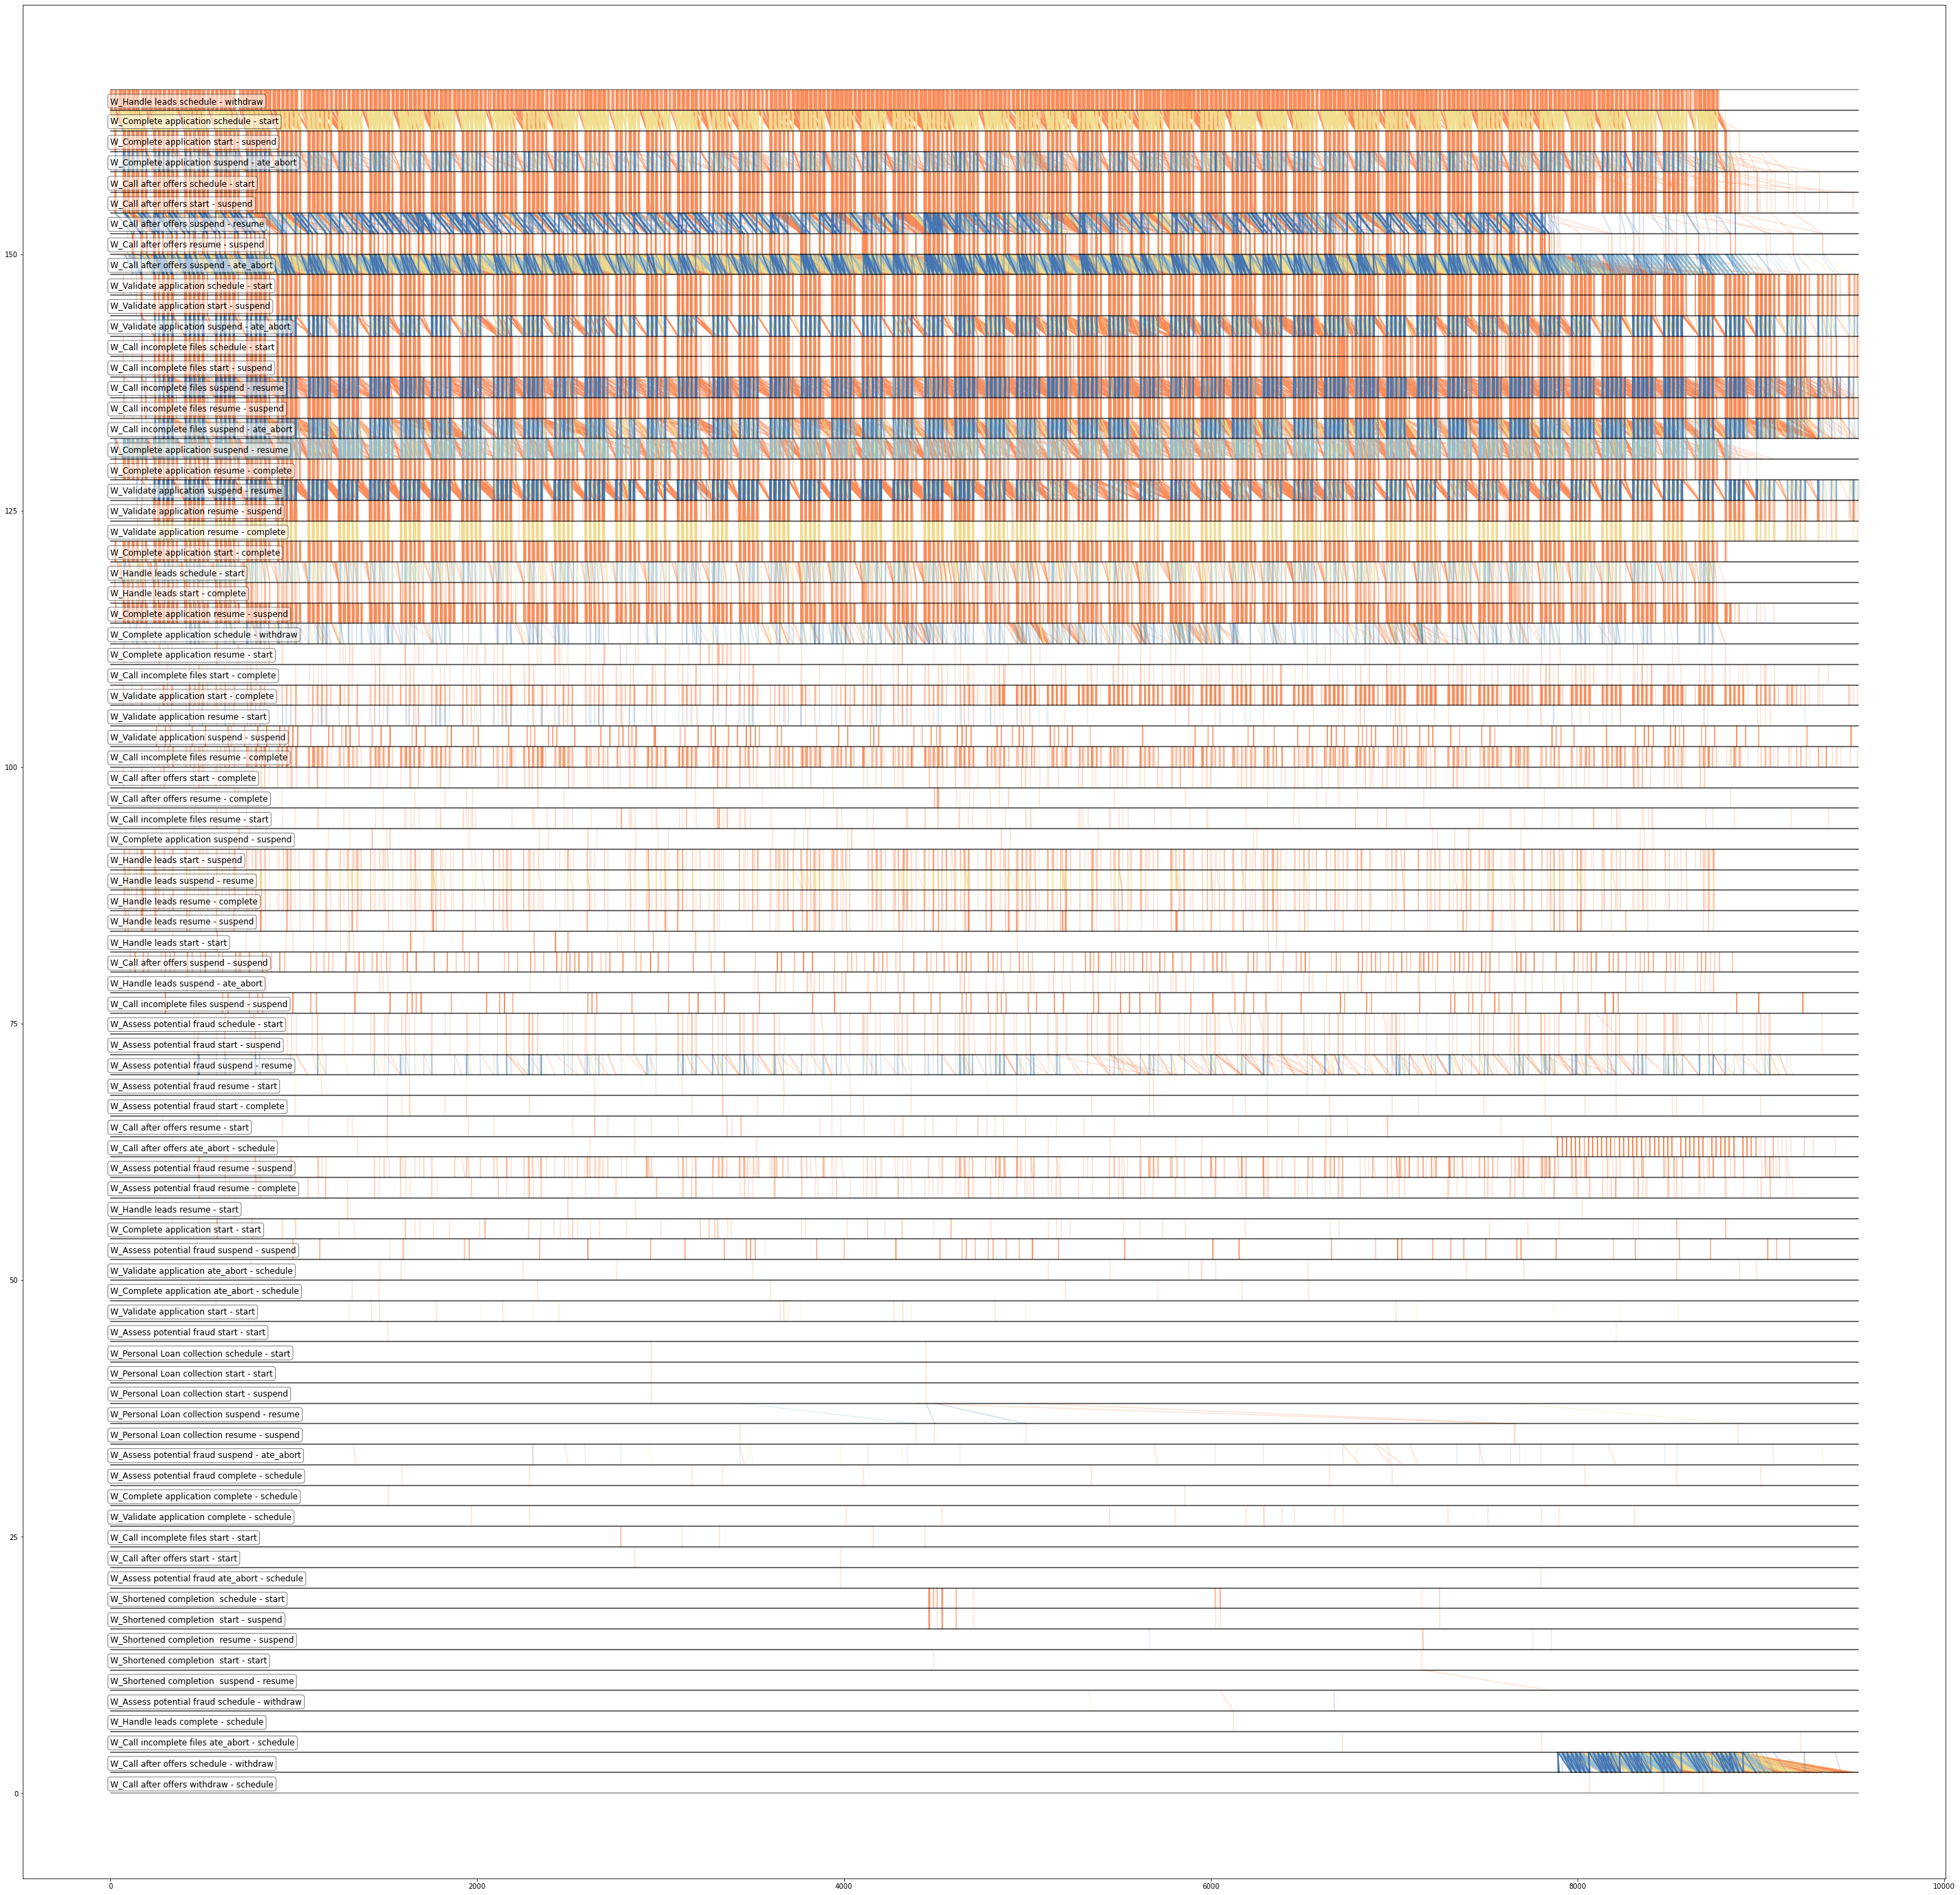

In [5]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[50,50])
bpi.plot_performance_spectrum(class_colors, ax)

In [18]:
bpi.pf = bpi.pf.sort_values('start_time')
bpi.pf['end_interval'] = bpi.pf['end_time'] // (7*24)
bpi.pf['start_interval'] = bpi.pf['start_time'] // (7*24)
intervals = bpi.pf['start_interval'].unique()
total = pd.DataFrame()
print(intervals)
for interval in intervals:
    cases = bpi.pf[(bpi.pf['end_interval'] > interval) & (bpi.pf['start_interval'] < interval+1)].copy()
    offset = ((cases['start_time'] - (interval* (7*24))).apply(lambda x: min(x,0)) + (((interval+1)* (7*24)) - cases['end_time']).apply(lambda x: min(x,0)))
    cases['weight'] = (cases['duration'] + offset)/(7*24)
    if len(cases) > 0:
        t = pd.DataFrame(cases.groupby(['segment_name', 'resource'])['weight'].sum())
        t.columns = ['count']
        t = t.reset_index()
        t.loc[t['resource'].str.contains(','), 'resource'] = t['resource'][t['resource'].str.contains(',')].apply(lambda x: ast.literal_eval(x)[-1])
        t['interval'] = interval
        total = total.append(t)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56.]


In [19]:
total = total.groupby(['segment_name', 'resource', 'interval'])['count'].sum()
total.columns = ['count']
total = total.reset_index()
working_segments = [s for s in bpi.segments if 'schedule' not in s]
working_hours = (total[total['segment_name'].isin(working_segments)].groupby('resource')['count'].mean())
working_hours = working_hours[working_hours != working_hours['User_1']]
working_segments

['W_Complete application start - suspend',
 'W_Complete application suspend - ate_abort',
 'W_Call after offers start - suspend',
 'W_Call after offers suspend - resume',
 'W_Call after offers resume - suspend',
 'W_Call after offers suspend - ate_abort',
 'W_Validate application start - suspend',
 'W_Validate application suspend - ate_abort',
 'W_Call incomplete files start - suspend',
 'W_Call incomplete files suspend - resume',
 'W_Call incomplete files resume - suspend',
 'W_Call incomplete files suspend - ate_abort',
 'W_Complete application suspend - resume',
 'W_Complete application resume - complete',
 'W_Validate application suspend - resume',
 'W_Validate application resume - suspend',
 'W_Validate application resume - complete',
 'W_Complete application start - complete',
 'W_Handle leads start - complete',
 'W_Complete application resume - suspend',
 'W_Complete application resume - start',
 'W_Call incomplete files start - complete',
 'W_Validate application start - comple

In [20]:
(working_hours * 24)

resource
User_10     56.582633
User_100     5.716609
User_101     9.050193
User_102    17.404181
User_103     3.571429
              ...    
User_95      4.796992
User_96     33.467857
User_97     27.428571
User_98     30.361905
User_99     16.082011
Name: count, Length: 143, dtype: float64

In [21]:
load = pd.DataFrame(total[total['segment_name'].isin(working_segments)].groupby(['resource', 'interval'])['count'].sum())
load.reset_index(inplace=True)
load

resource  interval     count
0      User_1       0.0  0.976190
1      User_1       1.0  1.107143
2      User_1       2.0  1.898810
3      User_1       3.0  0.845238
4      User_1       4.0  1.744048
...       ...       ...       ...
3803  User_99      45.0  0.005952
3804  User_99      47.0  0.517857
3805  User_99      48.0  0.017857
3806  User_99      49.0  0.255952
3807  User_99      54.0  0.422619

[3808 rows x 3 columns]

In [22]:
bpi.pf['load'] = bpi.pf['start_interval'].map(load.groupby('interval')['count'].sum())

In [23]:
queue = pd.DataFrame(total[~total['segment_name'].isin(working_segments)].groupby(['resource', 'interval'])['count'].sum())
queue.reset_index(inplace=True)
queue

resource  interval       count
0    User_1       0.0    6.535714
1    User_1       1.0    1.839286
2    User_1       2.0    7.565476
3    User_1       3.0    6.315476
4    User_1       4.0   14.446429
5    User_1       5.0    6.690476
6    User_1       6.0   16.642857
7    User_1       7.0    1.059524
8    User_1       8.0    1.148810
9    User_1       9.0    3.041667
10   User_1      10.0    1.160714
11   User_1      11.0    0.166667
12   User_1      12.0    1.940476
13   User_1      13.0    7.363095
14   User_1      14.0    1.184524
15   User_1      15.0    2.303571
16   User_1      16.0    2.476190
17   User_1      17.0    2.684524
18   User_1      18.0    3.363095
19   User_1      19.0    4.517857
20   User_1      20.0    2.839286
21   User_1      21.0   16.190476
22   User_1      22.0   10.488095
23   User_1      23.0   14.184524
24   User_1      24.0    6.339286
25   User_1      25.0   20.297619
26   User_1      26.0   19.071429
27   User_1      27.0    6.119048
28   User_1      28.0    4.505952
29   User_1      29.0   13.535714
30   User_1      30.0    7.416667
31   User_1      31.0    4.875000
32   User_1      32.0    6.363095
33   User_1      33.0    6.952381
34   User_1      34.0   13.142857
35   User_1      35.0    8.452381
36   User_1      36.0    7.535714
37   User_1      37.0    5.017857
38   User_1      38.0    0.119048
39   User_1      39.0    2.886905
40   User_1      40.0   10.285714
41   User_1      41.0   13.017857
42   User_1      42.0   11.035714
43   User_1      43.0    8.452381
44   User_1      44.0    7.065476
45   User_1      45.0   11.660714
46   User_1      46.0    5.375000
47   User_1      47.0  269.684524
48   User_1      48.0  466.279762
49   User_1      49.0  679.714286
50   User_1      50.0  739.750000
51   User_1      51.0  691.875000
52   User_1      52.0  631.196429
53   User_1      53.0  422.767857
54   User_1      54.0  217.339286
55   User_1      55.0   87.017857

In [24]:
load['date'] = load['interval'].apply(lambda x: bpi.first + datetime.timedelta(weeks=x))
queue['date'] = queue['interval'].apply(lambda x: bpi.first + datetime.timedelta(weeks=x))

Text(0.5, 0, 'Week-long interval')

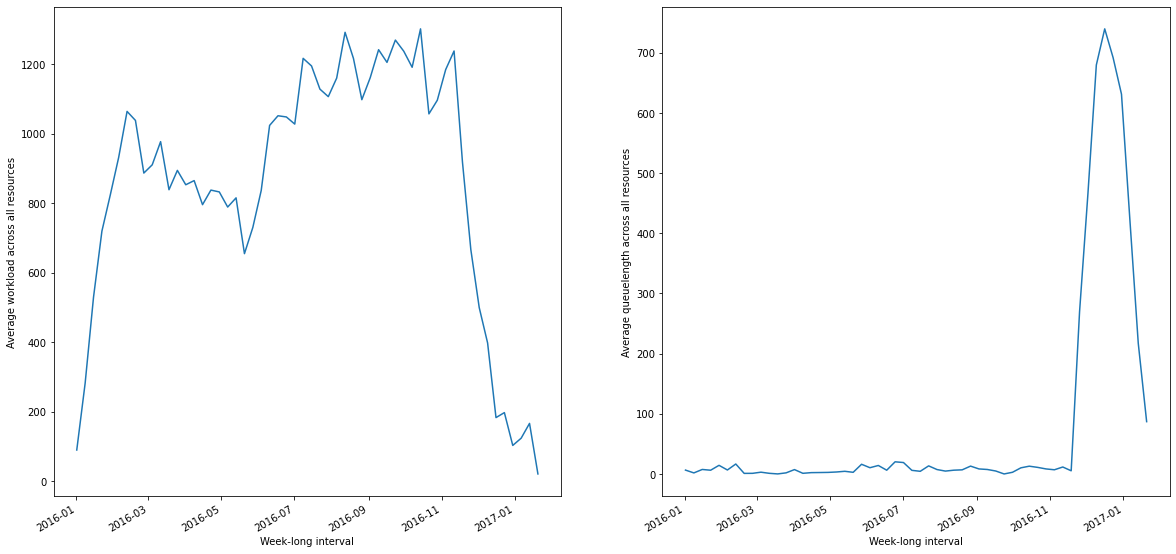

In [25]:
fig, ax = plt.subplots(ncols=2, figsize = [20,10])
load.groupby('date')['count'].sum().plot(ax=ax[0])
ax[0].set_ylabel('Average workload across all resources')
ax[0].set_xlabel('Week-long interval')
queue.groupby('date')['count'].sum().plot(ax=ax[1])
ax[1].set_ylabel('Average queuelength across all resources')
ax[1].set_xlabel('Week-long interval')

(0.0, 100.0)

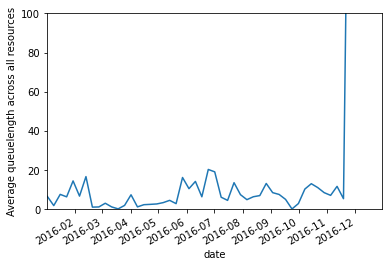

In [26]:
queue.groupby('date')['count'].sum().plot()
plt.ylabel('Average queuelength across all resources')

plt.xlim([queue['date'][0], queue['date'][52]])
plt.ylim([0,100])

In [27]:
bpi.pf['queue'] = bpi.pf['start_interval'].map(queue.groupby('interval')['count'].sum())

In [30]:
totalplot = pd.DataFrame()
toplot = load
coefs = {}
rsq = []
for i, resource in enumerate(toplot['resource'].unique()):
    x = toplot[toplot['resource'] == resource][['interval', 'count']]
    y = bpi.pf[(bpi.pf['resource'] == resource)].groupby('start_interval')['duration'].mean()
    x['duration'] = x['interval'].map(y)
    x = x.dropna()
    if len(x) > 2:
        try:
            lr = linear_model.RANSACRegressor(min_samples=5)
            lr.fit(X=np.array(x['count']).reshape(-1, 1), y=x['duration'])
            fitted = lr.predict(np.array(x['count']).reshape(-1, 1))
            inlier_mask = lr.inlier_mask_
            rsq.append(lr.score(np.array(x[inlier_mask]['count']).reshape(-1, 1), y=x[inlier_mask]['duration']))
    #         outlier_mask = np.logical_not(inlier_mask)
    #         ax = x[outlier_mask].plot(kind='scatter', x='count', y='duration', color='red')
    #         x[inlier_mask].plot(kind='scatter', x='count', y='duration', ax=ax)
    #         x['fitted'] = fitted
    #         x.plot(x='count', y='fitted', ax=ax)
    #         plt.title(resource)
            totalplot = totalplot.append(x)
            coefs[resource] = [lr.estimator_.coef_[0], lr.estimator_.intercept_]
        except ValueError:
            pass # data not big enough

c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\

c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\

c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\

c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\continuum\anaconda3\envs\bep\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\20173939\appdata\local\

In [32]:
rsq = np.array(rsq)
rsq[~np.isnan(rsq)].mean()

0.5587033785790807

Text(0.5, 0, 'Fitted regression coefficients')

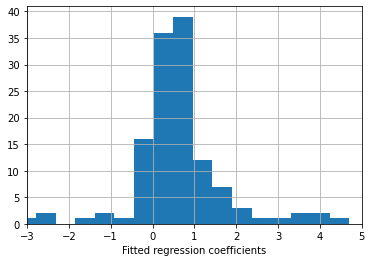

In [31]:
impact = pd.DataFrame(coefs).T
impact.columns = ['slope', 'intercept']
impact['slope'].hist(bins=40)
plt.xlim([-3,5])
plt.xlabel('Fitted regression coefficients')

Text(0, 0.5, 'average duration')

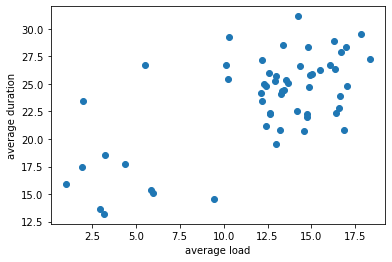

In [52]:
y = totalplot.groupby('interval')['duration'].mean()
x = totalplot.groupby('interval')['count'].mean()
plt.scatter(x,y)
plt.xlabel('average load')
plt.ylabel('average duration')

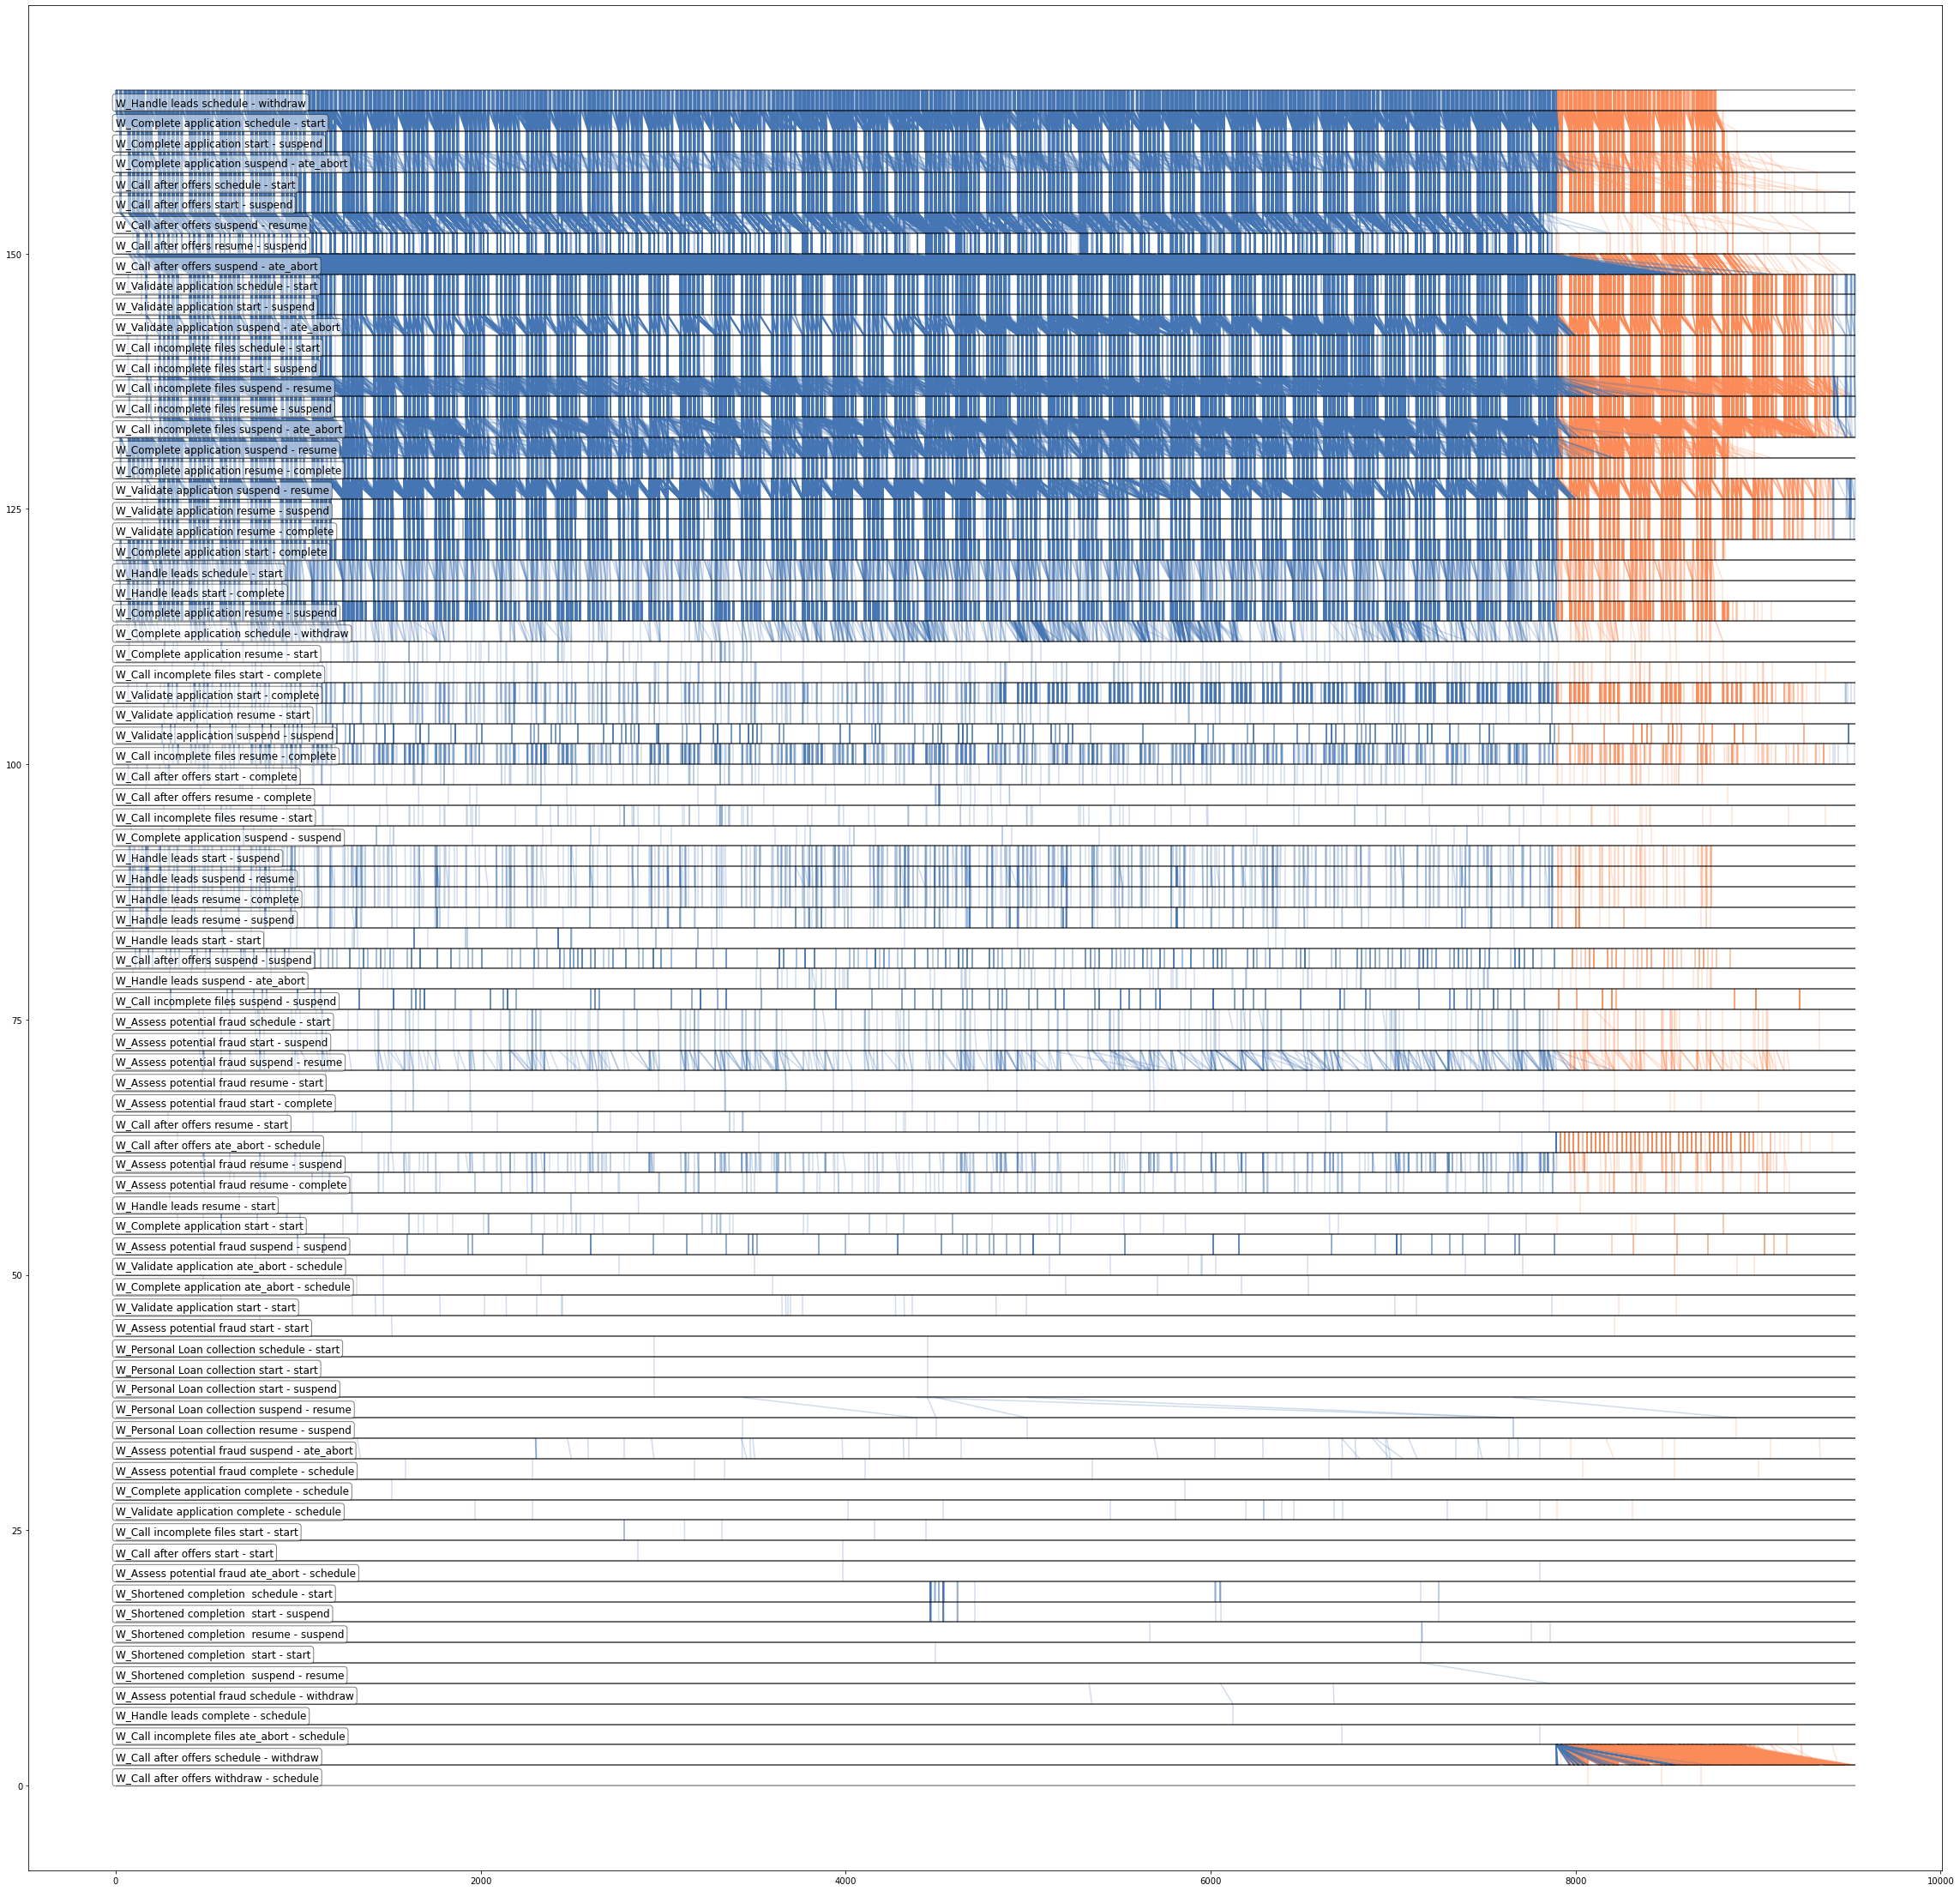

In [30]:
class_colors = [(69/256, 117/256, 180/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[40,40])
bpi.plot_performance_spectrum(class_colors, ax, mask=bpi.pf['queue'] > 25, vis_mask=True)

In [94]:
bpi.pf.to_csv('C:/Users/20173939/Documents/Study/BEP/bpi17.txt')